# Biomass reference map generation for Barro Colorado Island, Panama

This workflow is a demonstration of a framework for creating reference maps of live woody aboveground biomass (**AGB**) in R using airborne laser scanning (**ALS**) and field plot inventory data collected over plots located on Barro Colorado Island and the Gigante Peninsula in the Canal Zone, central Panama.

### Extending field inventories with airborne lidar
Using local relationships between forest inventory data and ALS, this workflow (i) demonstrates ALS processing and registration to field data, (ii) compares two modeling approaches to predict plot-level AGB from the ALS metrics, and (iii) produces AGB reference maps for large areas of forest. Users of this workflow will:

1. Prepare the workspace.
2. Access the ALS data and read it into a workspace.
3. Process the ALS data to produce terrain and canopy products and ALS metrics.
4. Access the field plot data and associated geospatial data.
5. Produce ALS metrics for field plots.
6. Quantify AGB from field plot data.
7. Build candidate models of AGB density from ALS metrics.
8. Validate the model.
9. Generate an AGB reference map for the entire ALS acquisition area.

<!-- Forest metrics such as canopy height and canopy cover can be extracted from discrete return lidar and related to aboveground biomass measurements from the field. This relationship produces a locally-calibrated model for predicting aboveground biomass from airborne lidar, and this model is applied to lidar data outside of the field plot to garner predictions of gridded aboveground biomass density.

The process will be following Armston et al. 2020. AfriSAR: Gridded Forest Biomass and Canopy Metrics Derived from LVIS, Gabon, 2016. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1775 -->

***

### **1.** Prepare the workspace.

This notebook is designed to run on the NASA MAAP in a "MAAP R Stable" workspace. To prepare the workspace, install packages via the terminal and restart the kernel in this notebook, or install from configuration file (this is much faster):
 
- `conda env update -f ./environments/biomass_panama.yml`
 
    <!-- - Code for saving the current environment as a .yml for later:
 
      `conda env export > ./environments/biomass_panama.yml`


      - When necessary, install packages individually with conda install:

        `conda install r-rcsf r-rstoolbox r-ggpubr
        r-sf r-future r-terra r-tidyverse r-lidr r-minpack.lm` -->


Some packages cannot be installed throuhg conda-forge. Install the necessary packages in R:

In [1]:
# # #these packages couldn't be found by conda, so install them with R temporarily

# install.packages('BIOMASS')
# install.packages('httr2')
# install.packages("randomForest")
# # install lasR
# # install.packages('lasR', repos = c('https://r-lidar.r-universe.dev', 
# #                                    'https://cloud.r-project.org'), 
# #                  dependencies = TRUE)
# install.packages("remotes")
# remotes::install_github("r-lidar/lasR", ref = "devel", dependencies = TRUE)
# remotes::install_github("njtierney/broomstick")
# install.packages("tidyterra")

In [2]:
# load in the required R packages

suppressMessages({
    library(broom)
    library(broomstick)
    library(ggpubr)
    library(sf)
    library(future)
    library(terra)
    library(lidR)
    library(RCSF)
    library(RStoolbox)
    library(BIOMASS)
    library(httr2)
    library(randomForest)
    library(tidyterra)
    library(tidyverse)
    library(lasR)

})


***

### **2.** Access the ALS data and read it into a workspace.

In [3]:
# make the subdirectories if they don't exist

root_dir = "./data/ALS/BCI_Gigante"
#root_dir = "./data/ALS/test"

dir_list = c(
                paste0(root_dir, "/output/_1_classified_points"),
                paste0(root_dir, "/output/_2_DTM_raster"),
                paste0(root_dir, "/output/_3_normalized_points"),
                paste0(root_dir, "/output/_4_CHM_raster"),
                paste0(root_dir, "/output/_5_metrics_raster"),
                paste0(root_dir, "/output/_6_subplots_points")
            )

for (i in seq_along(dir_list)) {

    dir_path = dir_list[i]
    
    ifelse(!dir.exists(file.path(dir_path)),
           dir.create(file.path(dir_path), recursive = TRUE), 
           FALSE)
    
    }


### **3.** Process the ALS data to produce terrain and canopy products and ALS metrics.

This workflow produces five levels of products, including two transformations of the point cloud, three categories of raster data, and point clouds clipped to field plot polygons. These product-producing steps are denoted as their file folder names in grey text. 

### <font color='grey'>_1_classified_points
In the first step, read in the ALS flightlines from their source with `lasR::reader()`; performing some filtering on read:
- One point per 2-cm voxel,
- Points above the lowest elevation expected at the site, to exclude belowground noise,
- Scan angles +/- 15 degrees from nadir,
- Return number and number of returns below 8, to exclude likely noise points with very high numbers of returns or return numbers.

Use an isolated voxel filter to classify isolated points occuring above or below the canopy as noise with `lasR::classify_with_ivf()`. Noise points will affect canopy metrics downstream, and should be removed. They can represent real returns from birds or aerosols or can be artifacts, especially near water features. 

Use a cloth simulation filter algorithm to classify ground points with `lasR::classify_with_csf()`. Ground classification is necessary to model terrain because point cloud Z values represent absolute elevation rather than canopy height. To quantify canopy height, it is necessary to subtract the elevation of terrain.  

In [4]:
# _1_classified_points

path_als = #paste0(root_dir, "/input_test")
        paste0(root_dir, "/input")

if (length(list.files(dir_list[1])) == 0) {
    
    # only read one point per 2x2 cm voxel,
    # drop points below the lowest elevation expected at the site
    # only read points with scan angles +/- 15 degrees from nadir,
    # drop likely noise points with very high numbers of returns or return numbers
    pipeline = reader(filter = "-thin_with_voxel .02
                                -keep_z_above 20
                                -drop_abs_scan_angle_above 15
                                -keep_return 1 2 3 4 5 6 7
                                -drop_number_of_returns 15
                                -drop_number_of_returns 14
                                -drop_number_of_returns 13
                                -drop_number_of_returns 12
                                -drop_number_of_returns 11
                                -drop_number_of_returns 10
                                -drop_number_of_returns 9
                                -drop_number_of_returns 8
                                -drop_withheld"
                                             ) +
 

            # classify points as noise if they have fewer than 200 points in their surrounding 10x10 m voxels,
            # for big clouds of above- or belowground noise
            classify_with_ivf(res = 10, n = 200L, class = 18L) +

            # classify points as noise if they have fewer than 30 points in their surrounding 5x5 m voxels
            classify_with_ivf(res = 5, n = 30L, class = 18L) +
            
            # classify ground points with a cloth simulation filter algorithm
            classify_with_csf(slope_smooth = FALSE,
                                class_threshold = 0.05,
                                cloth_resolution = 0.3,
                                rigidness = 3L,
                                iterations = 500L,
                                time_step = 0.6,
                                class = 2L,
                                # only let the algorithm use last returns that aren't noise
                                filter = "Classification != 18") +
            
            # write the point clouds with ground and noise points classified
            write_las(paste0(root_dir, "/output/_1_classified_points/*_ground.las"))
            
           
    exec(pipeline, 
         #on = CTG,
         on = path_als,
         ncores = 16, 
         # 600-x-600 m chunks
         with = list(chunk = 600),
         progress = FALSE)

    }


### <font color='grey'> _2_DTM_raster
From classified ground retuns, produce a raster of terrain elevations by producing a triangualted irregular network (TIN) with `lasR::triangulate()` from the lowest value within each pixel. Also perform some smoothing to produce a realistic model for canopy height normalization. 


In [5]:
# _2_DTM_raster

if (length(list.files(dir_list[2])) == 0) {
    
    pipeline = reader(filter = keep_ground()) +
    
            # # create a point cloud of only the lowest ground point in each 50 cm grid cell
            # # function to classify ground points that are not last returns as unclassified
            # # equivalent to -keep_last
            # callback(fun = function(data) {
            #     data |>
            #         dplyr::mutate(Classification =
            #                       if_else(Classification == 2 
            #                               & NumberOfReturns > 1 
            #                               & ReturnNumber == 1, 0, Classification))
            # }, 
            #          expose = "cnr") + 
    
            # keep only the lowest last return per pixel
            sampling_pixel(res = 1, 
                           operator = "min") +#, 
                           #filter = "!(NumberOfReturns > 1 & ReturnNumber == 1)") +

            # generate a triangulation of these points
            (tri = triangulate(max_edge = 120,
                             #use_low = TRUE, 
                              use_attribute = "Z")) +
            
            #rasterize the triangulation at a 1-m resolution 
           (dtm = rasterize(1, tri, ofile = paste0(root_dir, "/output/_2_DTM_raster/DTM.tif"))) +
            # (dtm = load_raster(paste0(root_dir, "/output/_2_DTM_raster/DTM.tif"))) +

            # apply a laplachian filter to replace spikes and pits with median values
            (spikefree1 = pit_fill(dtm,
                        lap_size = 5L,
                      thr_lap = 0.7,
                      thr_spk = -0.05,
                      med_size = 5L,
                      dil_radius = 1L,
                                   ofile = "")) +

            # perform this filter again at a coarser scale to capture larger spikes
            pit_fill(spikefree1,
                       lap_size = 10L,
                      thr_lap = 0.3,
                      thr_spk = -0.12,
                      med_size = 8L,
                      dil_radius = 1L,
                     ofile = paste0(root_dir, "/output/_2_DTM_raster/DTM_spikefree.tif"))
               

       
    lasR::exec(pipeline, 
         on = paste0(root_dir, "/output/_1_classified_points"),
        ncores = 12,
        with = list(buffer = 120),
         progress = FALSE)
    
    DTM = rast(paste0(root_dir, "/output/_2_DTM_raster/DTM_spikefree.tif"))
    DTM[!is.finite(DTM)] = NA
    
    #smooth the DTM a little bit
    DTM_smooth = DTM %>%
            terra::crop(ext(readLAScatalog(path_als))) %>%
            terra::focal(w=5, fun="median", na.policy="only", na.rm=TRUE) |>
            terra::focal(w = terra::focalMat(DTM, .75, "Gauss"), na.policy="all", na.rm=FALSE,
                         filename = paste0(root_dir, "/output/_2_DTM_raster/DTM_smooth.tif"), overwrite = TRUE)

    }

### <font color='grey'> _3_normalized_points
Subtract the terrain value from the Z values in the point cloud using `lasR::transform_with()` to produce a new point cloud where Z represents normalized canopy height. 

In [6]:
# _3_normalize_points

if (length(list.files(dir_list[3])) == 0) {
    
    pipeline = 

            lasR::reader_las(filter = #"Classification %in% c(0, 2)"
                                       "Classification != 18"
                            ) +

            # something about how the data are written by lasR requires
            # this transformation, float to double?
            callback(fun = function(data) {
                data |> dplyr::mutate(ScanAngle = abs(ScanAngle))
            }, 
                     # only read ScanAngle for faster processing
                     expose = "a") + 

            # load in the DTM from the previous step
            (dtm_smooth = load_raster(paste0(root_dir, "/output/_2_DTM_raster/DTM_smooth.tif"))) +

            # subtract the DTM from all Z vaues
            transform_with(dtm_smooth, "-") +
            
            write_las(paste0(root_dir, "/output/_3_normalized_points/*_norm.las"))

            
    exec(pipeline, 
         on = paste0(root_dir, "/output/_1_classified_points"),
         #on = paste0(root_dir, "/output/_3_normalize_height"),
         ncores = 20,
         with = list(buffer = 1),
         progress = FALSE)

    }


### <font color='grey'> _4_CHM_raster
Rasterize the normalized Z values with `lasR::chm()` to produce a canopy height model.


### <font color='grey'> _5_metrics_raster
Generate canopy metrics as predictors for modeling of AGB at a pixel resolution of 50 m:
- z_p99: the height below which 99% of returns occur,
- z_mean: the mean height of returns,
- z_cv: the coefficient of variation of return heights,
- z_above5: canopy cover above 5 m, 
- a_mean: mean absolute scan angle,
- z_count: the number of returns. 

Then generate derived metrics:
- slope: the mean slop derived from the DTM,
- volume: canopy volume as the sum of pixel heights from the smoothed CHM,
- LAI: leaf area index above 5 m; derived from canopy cover adjusted for scan angle
- n_ttops: the number of treetops detected with a local maximum treetop detection filter.


In [7]:
# _4_CHM_raster

if (length(list.files(dir_list[4])) == 0) {

    
    pipeline = 

            # drop noise points
            lasR::reader_las(filter = "Classification != 18") +

            chm(res = 1, tin = FALSE, ofile = paste0(root_dir, "/output/_4_CHM_raster/CHM.tif")) +

            delete_points(keep_z_above(0)) +
            rasterize(50, operators = c("z_p99", "z_mean", "z_cv", "z_above2", "z_above5", "a_mean", "z_count"), 
                      ofile = paste0(root_dir, "/output/_5_metrics_raster/metrics_50m.tif"))

            
    exec(pipeline, 
         on = paste0(root_dir, "/output/_3_normalized_points"),
         #on = paste0(root_dir, "/output/_3_normalize_height"),
         ncores = 12,
         progress = FALSE)

    # make a smooth, clean CHM for visualization and volume extraction 
    CHM = rast(paste0(root_dir, "/output/_4_CHM_raster/CHM.tif"))
    DTM_smooth = rast(paste0(root_dir, "/output/_2_DTM_raster/DTM_smooth.tif"))

    
    CHM_smooth = CHM %>%
            # any values below 0, set to 0
            terra::clamp(lower = 0, values = TRUE) %>%
            # fill in NA values with their neighbors' min value
            terra::focal(w=3, fun="min", na.policy="only", na.rm=TRUE, expand = FALSE) %>%
            ifel(!is.na(crop(DTM_smooth, .)) & is.na(.), 0, .) %>%
            # apply a median filter only to cells where there are big changes in Z value
            ifel(terra::terrain(., "TRI") > 5,
                 terra::focal(., w = 3, fun = "median", na.policy = "omit", na.rm = TRUE, expand = FALSE),
                 ., filename = paste0(root_dir, "/output/_4_CHM_raster/CHM_smooth.tif"), overwrite = TRUE)
    }


In [8]:
# _5_metrics_raster

# the metrics produced in the previous step, CHM, and DTM
metrics_50m = rast(paste0(root_dir, "/output/_5_metrics_raster/metrics_50m.tif")) |>
    # number of points / (50 * 50 m) to get point density    
    mutate(density = z_count / 2500) |>
    # at least 12 pts / m^2 and canopy cover above 10% (FAO definition of forest)
    filter(density > 12 & z_above2 > .1)


if (length(list.files(dir_list[5])) < 2) {

    CHM_smooth = rast(paste0(root_dir, "/output/_4_CHM_raster/CHM_smooth.tif")) |> crop(metrics_50m)
    DTM_smooth = rast(paste0(root_dir, "/output/_2_DTM_raster/DTM_smooth.tif")) |> crop(metrics_50m)
    
    #---------# volume
    # sum canopy height volume over each 50 m pixel
    volume = terra::resample(CHM_smooth, metrics_50m, method = "sum")
    
    #---------# LAI
    # convert fractional cover to LAI, according to scan angle
    # LAI cannot be calculated with a fractional cover of 100%
    # for pixels with no points below the threshold, add 1 artificial point below it
    cover_new = metrics_50m$z_count / (metrics_50m$z_count + 1)
    
    cover = metrics_50m$z_above5 %>%
        ifel(. == 1, cover_new, .)
    
    LAI = (-1/.5) * log(1 - cover) * cos(metrics_50m$a_mean /180*pi) 
    
    #---------# slope
    # produce slopes from 1 m DTM, then average over 50 m pixels
    slope = terra::terrain(DTM_smooth, v = "slope", 
                           filename = paste0(root_dir, "/output/_5_metrics_raster/slope_1m.tif"),
                          overwrite = TRUE) %>%
        terra::resample(metrics_50m, method = "average")

    #---------# aspect
    # produce slopes from 1 m DTM, then average over 50 m pixels
    aspect = terra::terrain(DTM_smooth, v = "aspect", unit = "radians") |>
        # cosine to convert to "northness"
        app(cos,
            filename = paste0(root_dir, "/output/_5_metrics_raster/aspect_1m.tif"),
            overwrite = TRUE) |>
        terra::resample(metrics_50m, method = "average")
    
    # #---------# elevation
    # # average terrain elevation over 50 m pixels
    # elevation = DTM_smooth %>%
    #     terra::resample(metrics_50m, method = "average")
    
    # combine the metrics of interest as predictors
    predictors = c(metrics_50m$z_p99, volume, LAI, metrics_50m$z_cv, slope, aspect)
    names(predictors) = c("Z_p99", "Volume", "LAI_5m", "Z_CV", "Slope", "Aspect")
    names(predictors)
    
    writeRaster(predictors, filename = paste0(root_dir, "/output/_5_metrics_raster/predictors_50m.tif"), 
                overwrite = TRUE)

    }


#### Generate figures illustrating ALS processing and canopy and terrain products:



In [9]:
# define some variables for plotting point cloud transects in ggplot

theme_transect = theme(
    panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
    panel.grid.major.x = element_blank(),
    panel.grid.minor.x = element_blank(),
        #axis.text.x = element_text(angle = 90),
        axis.ticks = element_blank(),
        axis.title.x = element_text(margin = ggplot2::margin(16, 3, 3, 3)),
        axis.title.y = element_text(margin = ggplot2::margin(3, 16, 3, 3)),
        legend.position = "inside",
        legend.position.inside = c(.987, .95),
        legend.justification = c(1, 1),
        panel.background = element_rect(fill = "white"),
        legend.key = element_rect(fill = "white", color = "white"),
        legend.title = element_blank(),
        legend.direction = "vertical",
        legend.key.width = unit(.3, "in"),
        legend.key.height = unit(.3, "in"),
        legend.background = element_rect(color = "black", fill = "white", linewidth = .5),
        legend.margin = ggplot2::margin(6, 6, 6, 6))

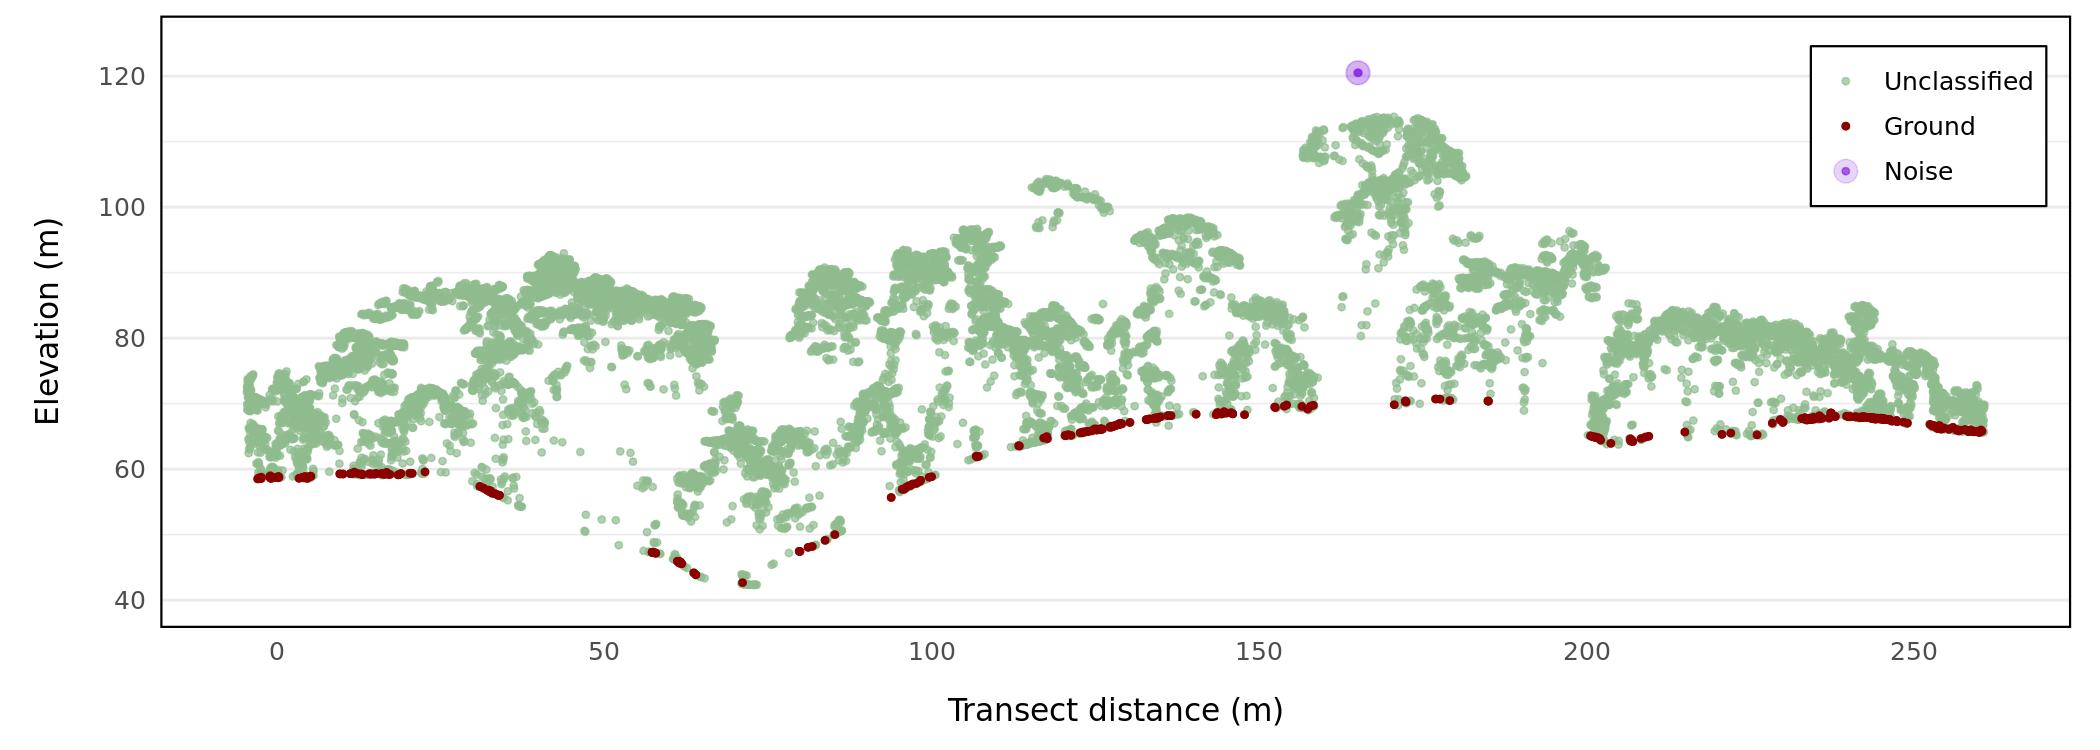

In [10]:
# identify tile that overlaps with transect

transect = data.frame(lon = c(625584, 625321),
                    lat = c(1012871, 1012906),
                   type = "transect") |>
    st_as_sf(coords = c("lon", "lat"), crs = 32617) |>
    dplyr::group_by(type) %>% 
    dplyr::summarise() %>% 
    st_cast("LINESTRING")


path_transect = (readLAScatalog(paste0(root_dir, "/output/_1_classified_points/")) |>
    catalog_intersect(transect))$filename


p1 = c(625584, 1012871) 
p2 = c(625321 , 1012905.5)
las = readLAS(path_transect)
las_tr = clip_transect(las, p1, p2, width = 2, xz = TRUE)


fig = ggplot(payload(las_tr), aes(X,Z, color = factor(Classification))) + 
  geom_point(size = 1.3, alpha = .7) + 
    geom_point(data = filter(payload(las_tr), Classification == 18),
               size = 5, alpha = .2) + 
    geom_point(data = filter(payload(las_tr), Classification == 2),
               size = 1.3, alpha = 1) + 
  coord_equal() + 
  theme_bw(base_size = 15) +
   scale_x_continuous(expand = expansion(mult = c(.05, .05)),
                     breaks = seq(0, 250, 50)) + 
   lims(y = c(40, 125)) +
    theme_transect +
    labs(x = "Transect distance (m)", y = "Elevation (m)") +
    scale_color_manual(labels = c("0" = "Unclassified",
                                  "2" = "Ground",
                                 "18" = "Noise"),
                      values = c("darkseagreen", "red4", "blueviolet"))

ggsave(plot = fig, 
       filename = "./figures/point_clouds/cross_section_classified.jpeg", 
       device = jpeg,
       width = 14,
       height = 5,
       units = "in",
       dpi = 150,
       bg = "white",
      create.dir = TRUE)

# plot classified points
IRdisplay::display_jpeg(file = "./figures/point_clouds/cross_section_classified.jpeg") 


**A cross section of a point cloud illustrating points classified as noise with the isolated voxels filter and as ground with the cloth simulation filter.**

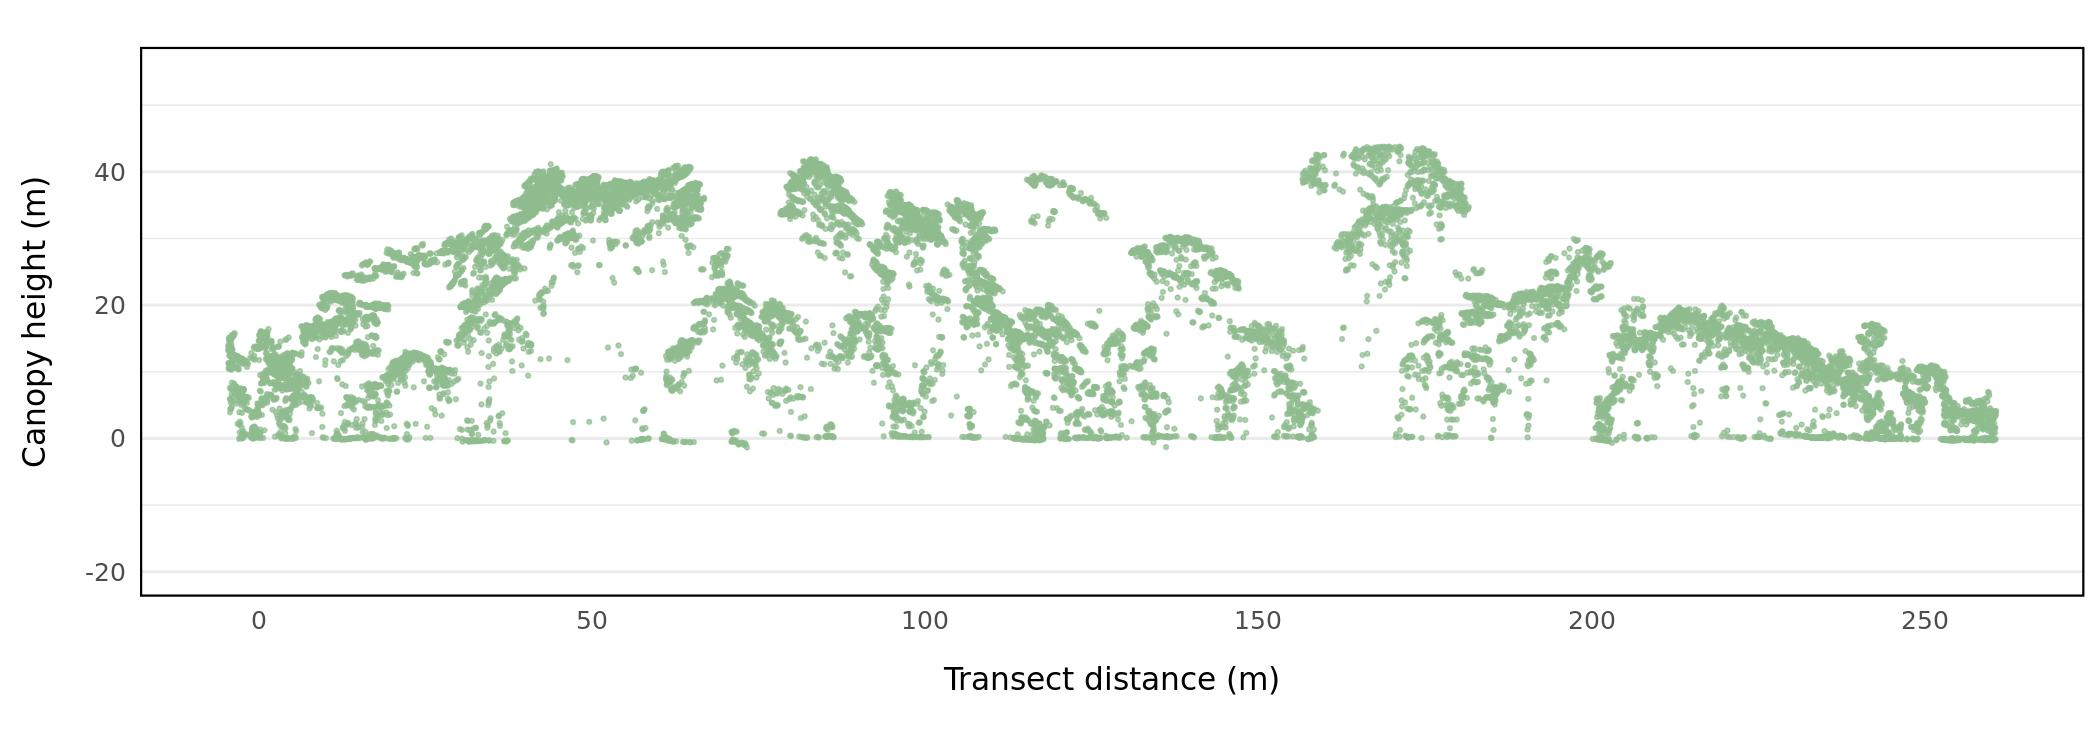

In [11]:
# plot transect canopy height
path_transect = (readLAScatalog(paste0(root_dir, "/output/_3_normalized_points/")) |>
    catalog_intersect(transect))$filename


p1 = c(625584, 1012871) 
p2 = c(625321 , 1012905.5)
las = readLAS(path_transect) #|>
    #filter_poi(Classification != "2")
las_tr = clip_transect(las, p1, p2, width = 2, xz = TRUE)


fig = ggplot(payload(las_tr), aes(X,Z)) + 
  geom_point(size = 1.3, alpha = .7, shape = 20, color = "darkseagreen") + 
  coord_equal() + 
  theme_bw(base_size = 15) +
   scale_x_continuous(expand = expansion(mult = c(.05, .05)),
                     breaks = seq(0, 250, 50)) + 
   lims(y = c(-20, 55)) +
    theme_transect +
    labs(x = "Transect distance (m)", y = "Canopy height (m)") +
    guides(legend.position = "none")

ggsave(plot = fig, 
       filename = "./figures/point_clouds/cross_section_normalized.jpeg", 
       device = jpeg,
       width = 14,
       height = 5,
       units = "in",
       dpi = 150,
       bg = "white")

# plot normalized points
IRdisplay::display_jpeg(file = "./figures/point_clouds/cross_section_normalized.jpeg") 


**A cross section of a point cloud illustrating points with Z values representing canopy height, after normalization to a digital terrain model.**


### **4.** Access the field plot data and associated geospatial data.

Read in plot shapefiles as sf (simple feature) object in the sf package.

In [12]:
# define some variables for mapping in ggplot

theme_map = theme(panel.border = element_rect(color = "black", fill = NA, linewidth = 1),
        axis.title = element_blank(),
        axis.text.x = element_text(angle = 90),
        axis.ticks = element_blank(),
        legend.position = "inside",
        legend.position.inside = c(.98, .02),
        legend.justification = c(1, 0),
        panel.background = element_rect(fill = "white"),
        legend.key = element_rect(fill = "white", color = "white"),
        legend.title = element_text(hjust = 0.5),
        legend.direction = "horizontal",
        legend.key.width = unit(.45, "in"),
        legend.key.height = unit(.1, "in"),
        legend.background = element_rect(color = "black", fill = "white", linewidth = .5),
        legend.margin = ggplot2::margin(4, 10, 4, 10))

cols_gradient <- c(low = "#002070", mid = "#DD6677", high = "#F1F1A1")
cols_gradient_biomass <- c(low = "#002070", mid = "#309040", high = "#D0E358")
cols_gradient_metrics <- c(low = "#00333A", mid = "#637F8A", high = "beige")


preds_50m = rast(paste0(root_dir, "/output/_5_metrics_raster/predictors_50m.tif"))
CHM = rast(paste0(root_dir, "/output/_4_CHM_raster/CHM.tif")) |> crop(preds_50m)
CHM_smooth = rast(paste0(root_dir, "/output/_4_CHM_raster/CHM_smooth.tif")) |> crop(preds_50m)
DTM_smooth = rast(paste0(root_dir, "/output/_2_DTM_raster/DTM_smooth.tif")) |> crop(preds_50m)

In [13]:
# read in plot polygons as sf objects

# note that read_sf() is silent, while st_read() prints a lot of information
# the 50-ha plot of Barro Colorado Island
bci_50ha_plot = read_sf('/projects/shared-buckets/samuel.grubinger/GIS/BCI_50ha.shp') |>
    mutate(NAME = "50-ha plot",
           AREA_HA = AREA,
           ORIGIN_X = 625773.86,
           ORIGIN_Y = 1011775.84) |>
    dplyr::select(NAME, AREA_HA, ORIGIN_X, ORIGIN_Y, geometry) 

# several 1-ha sattelite plots that were also censused in 2023
small_plots = read_sf('/projects/shared-buckets/samuel.grubinger/GIS/CTFS_Plots_Polygons.shp') |>
    mutate(NAME = DESC_,
          ORIGIN_X = Origin_X,
          ORIGIN_Y = Origin_Y) |>
    dplyr::select(NAME, AREA_HA, ORIGIN_X, ORIGIN_Y, geometry) |>
    st_set_crs(32617)

# combine all plots for each site
plots = bind_rows(bci_50ha_plot, small_plots) |>
    filter(NAME %in% c("50-ha plot", "P12", "P14", "Gigante2"))

# this buffered version will be used for cropping raster data for plotting
plots_buf_200m = plots |>
    st_centroid() |>
    st_buffer(200) |>
    suppressWarnings()

In [14]:
# calculate plot rotations from true north

# read in plot data
# get deviation from true north
# only works if plot origin is in the southwest corner

suppressWarnings({

plot_rotations = plots |>
    st_cast("POINT") %>%
    dplyr::mutate(X = sf::st_coordinates(.)[,1],
                Y = sf::st_coordinates(.)[,2]) |>
    group_by(NAME) |> 
    distinct(NAME, X, Y, geometry, ORIGIN_X, ORIGIN_Y) |>
    st_drop_geometry() |>
    arrange(X) |>
    slice_head(n = 2) |>
    mutate(point_ID = order(Y)) |>
    ungroup() |>
    pivot_wider(names_from = "point_ID", values_from = c("X", "Y")) |>
    mutate(theta = atan2(X_2 - X_1, Y_2 - Y_1),
          theta_degrees = (theta * 180) / (pi)) |>
    dplyr::select(NAME, ORIGIN_X, ORIGIN_Y, theta, theta_degrees)

plots_rot = left_join(plots, plot_rotations)

})


Joining with `by = join_by(NAME, ORIGIN_X, ORIGIN_Y)`


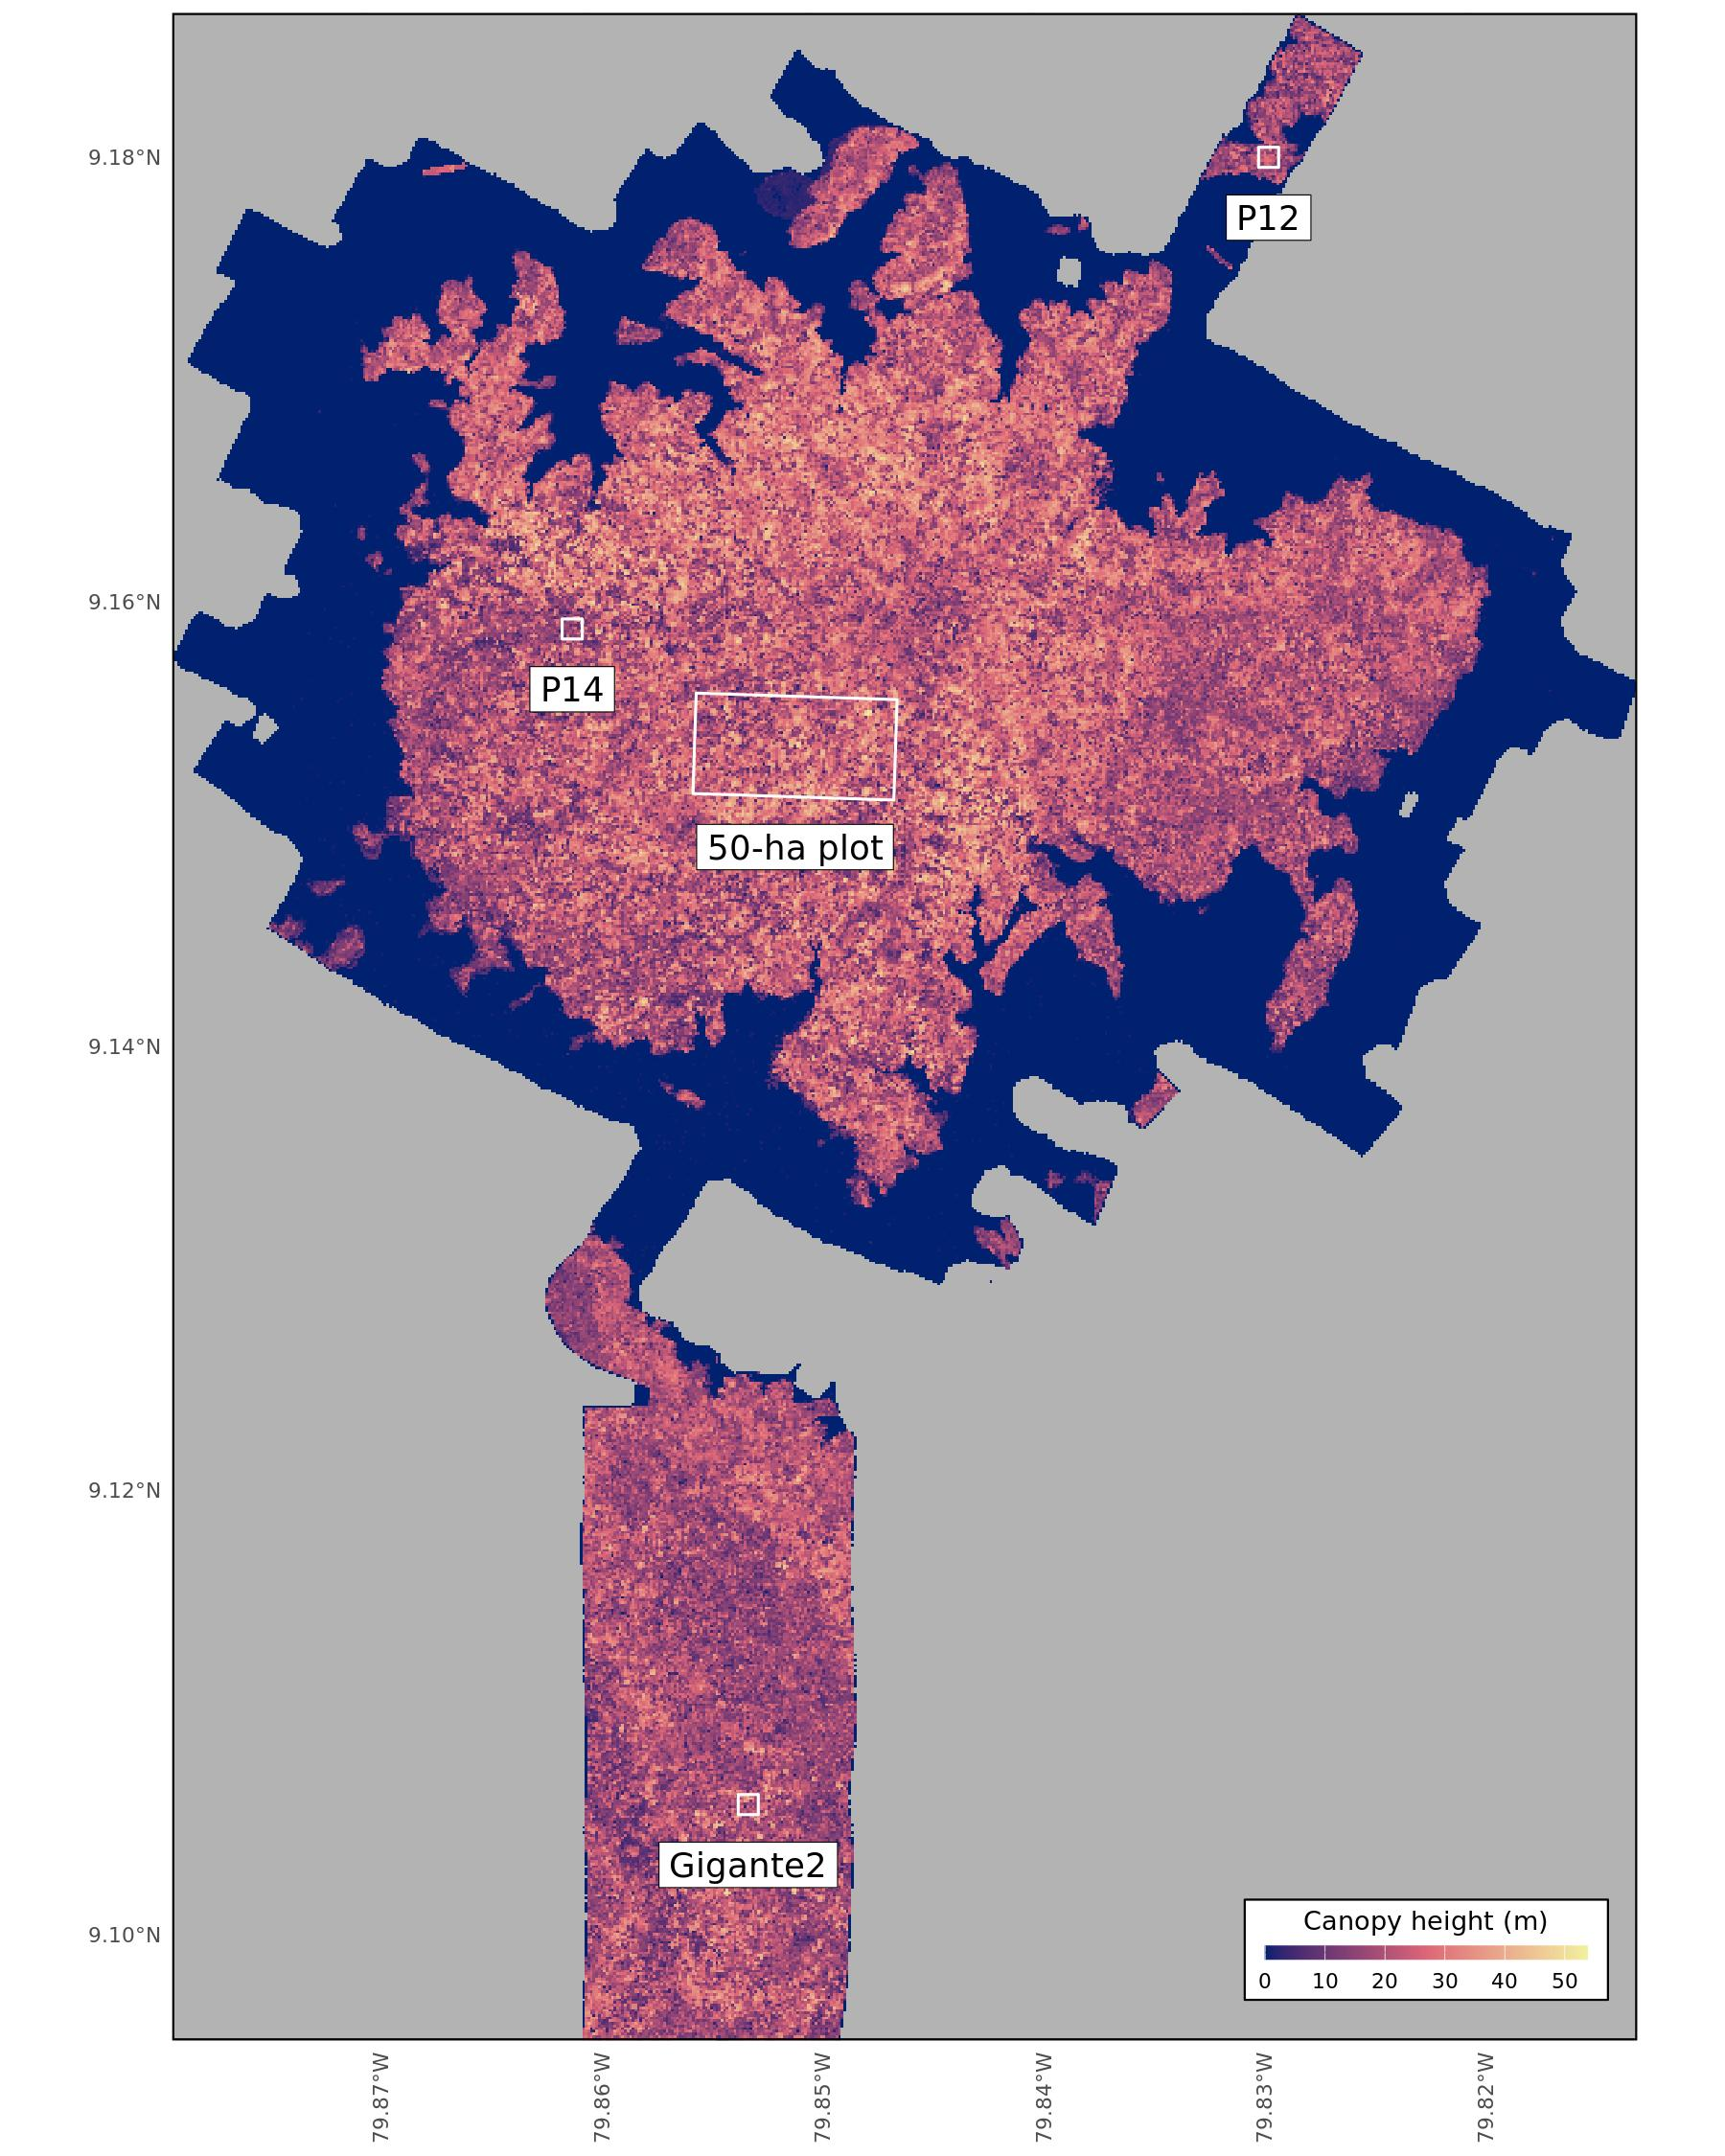

In [15]:
# plot the whole study area 

suppressMessages({

coverage_CHM = ggR(CHM_smooth |>
                     clamp(lower = 0),
           geom_raster = TRUE) +
    scale_fill_gradientn(colors = cols_gradient,
                         na.value = "grey70",
                        # limits = c(range_CHM),
                        name = "Canopy height (m)") +
   geom_sf(data = plots, color = "white", fill = NA, linewidth = .7) +
    #geom_sf(data = subplots, color = "white", fill = NA, linewidth = .4) +
     geom_sf_label(data = plots |> filter(NAME != "50-ha plot"), 
                   aes(label = NAME),
                   nudge_y = -300,
                    size = 6, 
            label.r = unit(0, "pt")) +
      geom_sf_label(data = plots |> filter(NAME == "50-ha plot"), 
                   aes(label = NAME),
                   nudge_y = -500,
                    size = 6, 
            label.r = unit(0, "pt")) +
   scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
   scale_y_continuous(expand = expansion(mult = c(-.13, 0))) +
     theme_bw(base_size = 13) +
   theme_map +
    #coord_sf(crs = 32617) +
    guides(fill = guide_colourbar(title.position="top"))

})
    
ggsave(plot = coverage_CHM, 
       filename = "./figures/raster/CHM_BCI_Gigante.jpeg", 
       device = jpeg,
       width = 12,
       height = 15,
       units = "in",
       dpi = 150,
       bg = "white",
      create.dir = TRUE)

IRdisplay::display_jpeg(file = "./figures/raster/CHM_BCI_Gigante.jpeg") 


**The full canopy height model (CHM) for the study area, with field plot boundaries outlined in white. The study area covers all of Barro Colorado Island in the center, a portion of the Buena Vista Peninsula to the north, and a portion of the Gigante Peninsula to the south.**

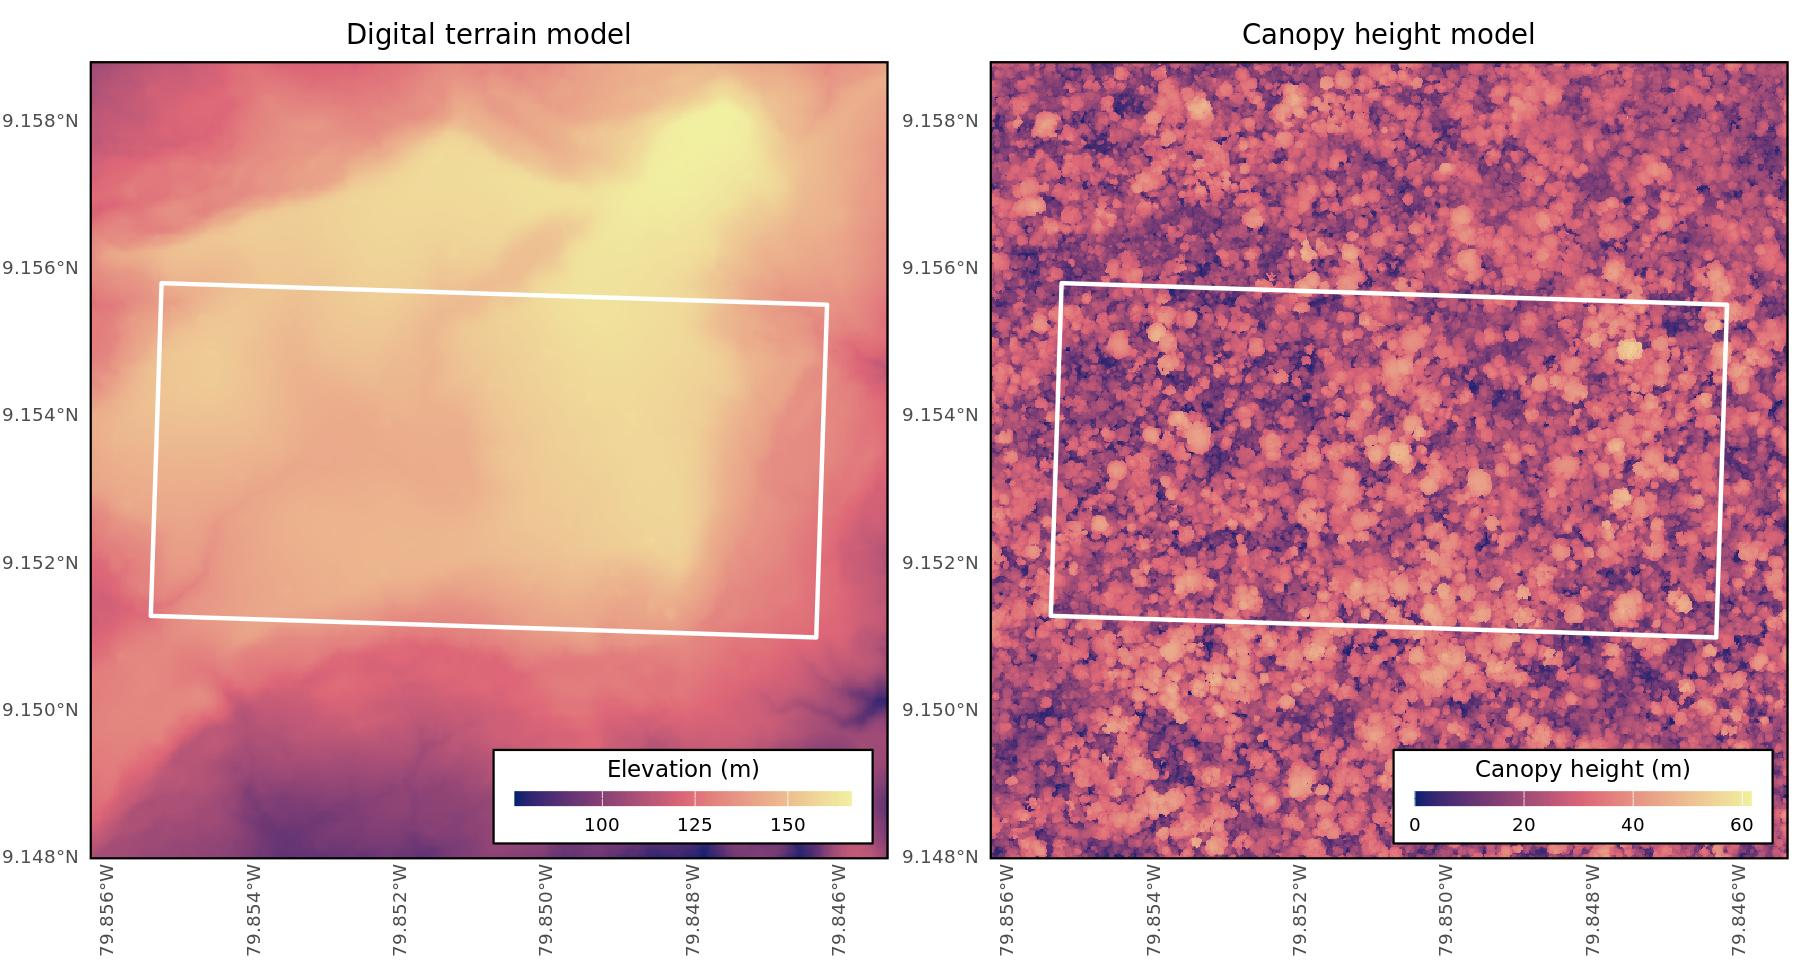

In [16]:
# plot the DTM and CHM for the 50-ha plot

range_DTM = DTM_smooth |> minmax()
range_CHM = CHM_smooth |> minmax()

suppressMessages({
    
p_DTM = ggR(DTM_smooth |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient,
                                na.value = "grey70",
                                # limits = c(range_DTM),
                                name = "Elevation (m)") +
           geom_sf(data = plots[1,], color = "white", fill = NA, linewidth = 1) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 11) +
           theme_map +
            ggtitle("Digital terrain model") +
          theme(plot.title = element_text(hjust = 0.5)) +
            guides(fill = guide_colourbar(title.position="top"))

p_CHM = ggR(CHM_smooth |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient,
                                na.value = "grey20",
                                limits = c(range_CHM),
                                name = "Canopy height (m)") +
           geom_sf(data = plots[1,], color = "white", fill = NA, linewidth = 1) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 11) +
           theme_map +
            ggtitle("Canopy height model") +
          theme(plot.title = element_text(hjust = 0.5)) +
            guides(fill = guide_colourbar(title.position="top"))

fig = ggarrange(p_DTM, p_CHM,
        ncol = 2, nrow = 1)

})
    
ggsave(plot = fig, 
       filename = "./figures/raster/DTM_CHM_50ha.jpeg", 
       device = jpeg,
       width = 12,
       height = 6.5,
       units = "in",
       dpi = 150,
       bg = "white",
      create.dir = TRUE)

IRdisplay::display_jpeg(file = "./figures/raster/DTM_CHM_50ha.jpeg") 

**A subset of the digital terrain model (DTM) and the canopy height model (CHM) for the 50-ha field plot on Barro Colorado Island, outline shown in white.**

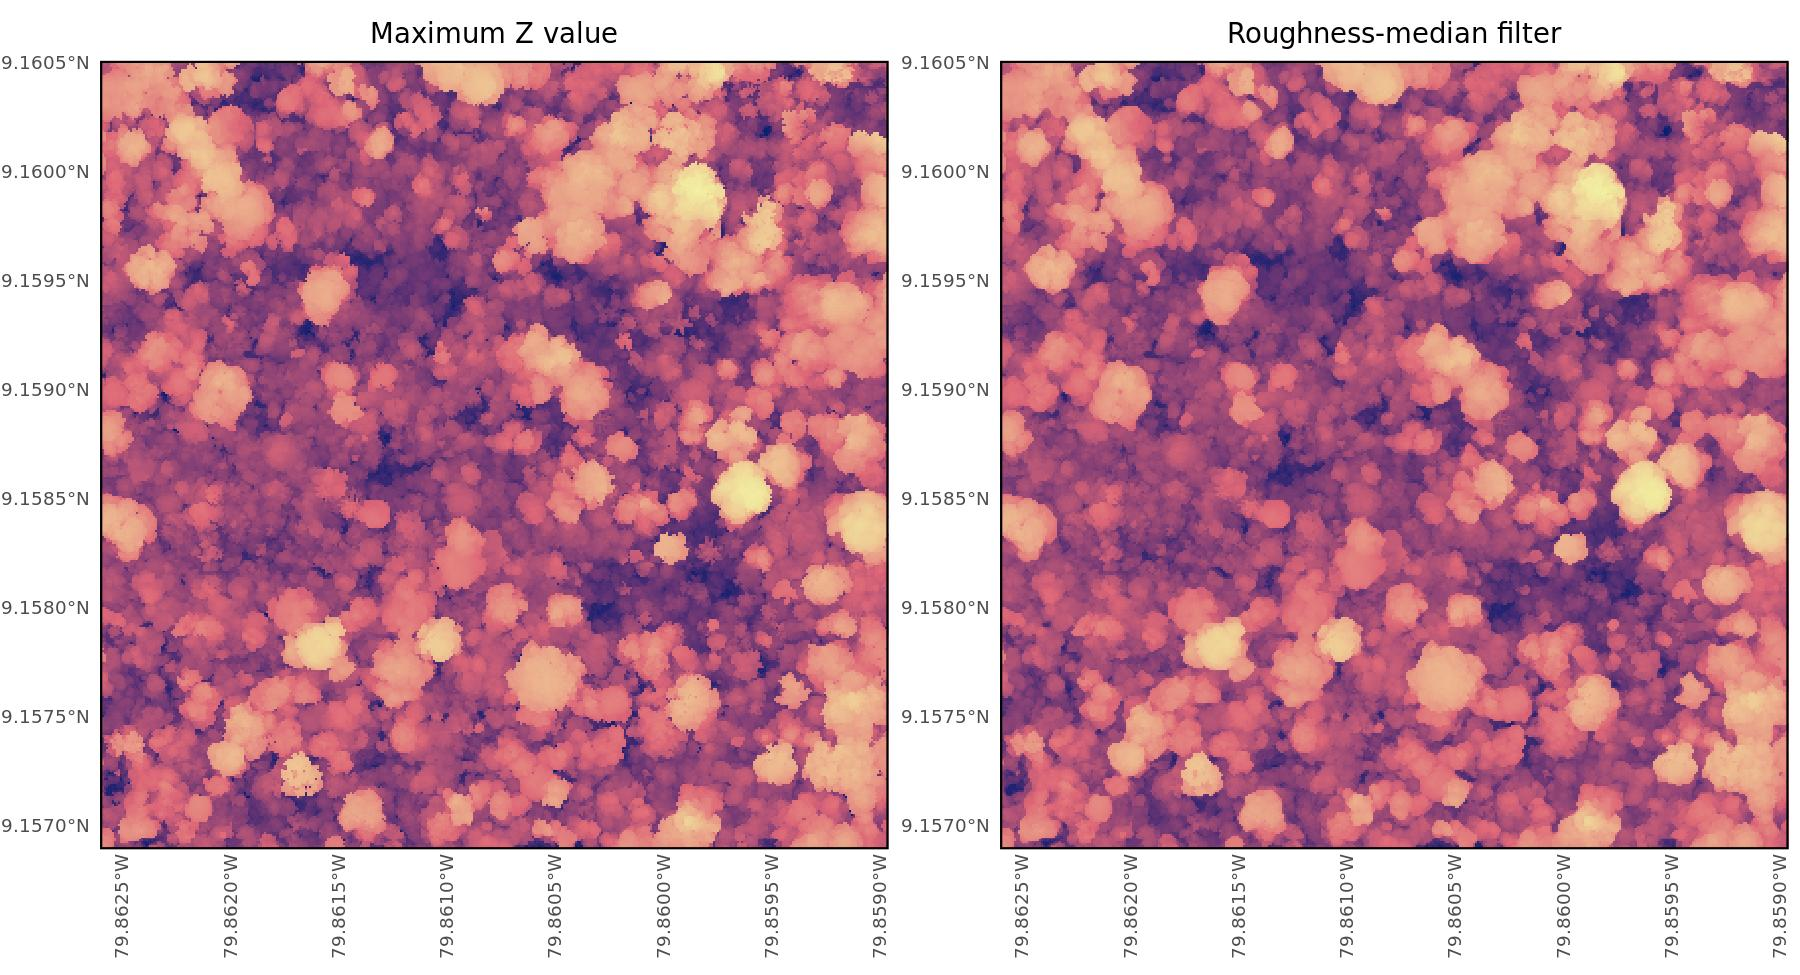

In [17]:
# plots for CHM filtering

suppressMessages({

p1 = ggplot() +
    ggR(CHM |> terra::crop(plots_buf_200m[2,]),
           geom_raster= TRUE, ggLayer = TRUE) +
    scale_fill_gradientn(colors = cols_gradient,
                         na.value = cols_gradient[[1]],
                        name = "Canopy height (m)") +
   #geom_sf(data = plots[1,], color = "red3", fill = NA, linewidth = 1) +
   scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
   scale_y_continuous(expand = expansion(mult = c(0, 0))) +
    theme_bw(base_size = 11) +
   theme_map +
    coord_sf(crs = 32617) +
    guides(fill = "none") +
  ggtitle("Maximum Z value") +
  theme(plot.title = element_text(hjust = 0.5))

p2 = p1 + ggR(CHM_smooth |> terra::crop(plots_buf_200m[2,]),
           geom_raster= TRUE, ggLayer = TRUE) +
  ggtitle("Roughness-median filter")

fig = ggarrange(p1, p2,
        ncol = 2, nrow = 1)

})
    
ggsave(plot = fig, 
       filename = "./figures/raster/CHM_filter.jpeg", 
       device = jpeg,
       width = 12,
       height = 6.5,
       units = "in",
       dpi = 150,
       bg = "white")

# plot CHM and cleaned CHM
IRdisplay::display_jpeg(file = "./figures/raster/CHM_filter.jpeg") 


**A subset of the unfiltered canopy height model (the maxmimum Z value of each cell) and the cleaned canopy height model (the result of the roughness-median filter).**

<font color='darkgreen'>
This smoothing fills in some missing pixels and catches some low noise; mostly it improves the appearance of the CHM rather than changing values drastically. I have not tested it scientifically.  
</font>

In [18]:
# loop through plots to create 50 x 50 m subplots for analysis

# if the plot polygons represent entire plots, not 50 x 50 m
# subplots, then they need to be divided into square subplots at a given resolution 
# in practice this is meant to produce 50 x 50 m subplots from large plots 
# (often 1 ha plots, 100 x 100 m)
# these subplots are equivalent to the pixel resolution of the output biomass maps


# Rotation function, angle in degrees
rotation = function(r){
  #r <- a * pi / 180 # degrees to radians
  matrix(c(cos(r), sin(r), -sin(r), cos(r)), nrow = 2, ncol = 2)
} 

subplot_res = 50 
subplots_list = list()

suppressWarnings({

for (i in seq_along(plots_rot$NAME)) {

    # exctract plot 1 by 1
    plot_i = plots_rot |>
        filter(NAME == plots_rot$NAME[i])
    
    # each plot's origin
    offset_i = c(plot_i$ORIGIN_X, plot_i$ORIGIN_Y)

    # each plot's rotation from true north
    theta_i = plot_i$theta
    
    subs = plot_i |>
        # overlay a grid of the desired pixel resolution
        st_make_grid(cellsize = subplot_res, 
                     offset = offset_i,
                     what = "polygons") %>%
        # convert from sfc to sf
        st_sf(geometry = .) |>

        # generate 1-ha plots for cross validation later
        # rank the X and Y coords (1, 2, 3, 4...)
        # and then count them by twos (1, 1, 2, 2...)
        rowwise() |>
        mutate(id_X = st_centroid(geometry)[[1]][1],
              id_Y = st_centroid(geometry)[[1]][2]) |>
        ungroup() |>
        mutate(id_X = ceiling(dense_rank(id_X)/2),
              id_Y = ceiling(dense_rank(id_Y)/2)) |>

    
        # apply the rotation to the north-oriented grid
        mutate(geometry = (geometry - offset_i) * rotation(theta_i) + offset_i) |>
        st_set_crs(32617)  |> 
        st_as_sf() |>
        # get the area of the overlap between the plot polygon and the new subplots
        st_intersection(plot_i, sparse = FALSE) |>
        mutate(area = as.numeric(st_area(geometry, by_element = TRUE))) |>
        # keep subplots with at least 95% overlap with the plot polygon,
        # allowing for some error in polygon delineation or plot corner coordinates
        filter(area >= (subplot_res^2 * .95)) |>
        st_cast("POLYGON") |>
        # name the subplots by centroid coordinate,
        # by X order, then Y order, from origin
        # first replace all special characters with _ in the plot names, for filename paths
        mutate(NAME_clean = str_replace_all(NAME, "[^[:alnum:]]", "_")) %>%
        rowwise() %>%
        mutate(centroid_X = round(st_centroid(geometry)[[1]][1]),
              centroid_Y = round(st_centroid(geometry)[[1]][2]),
              NAME_subplot = paste(NAME_clean, centroid_X, centroid_Y, sep = "_"),
               # name of 1 ha blocks, by index, not geographic coords
              NAME_1ha = paste(NAME_clean, "_", id_X, "_", id_Y)) |>
        dplyr::select(-NAME_clean)

        # add the subplots for each plot to a list to be combined later
        subplots_list[[i]] = subs
    }
})

# combine the elements of the list into a single sf object
subplots = sf::st_as_sf(data.table::rbindlist(subplots_list))


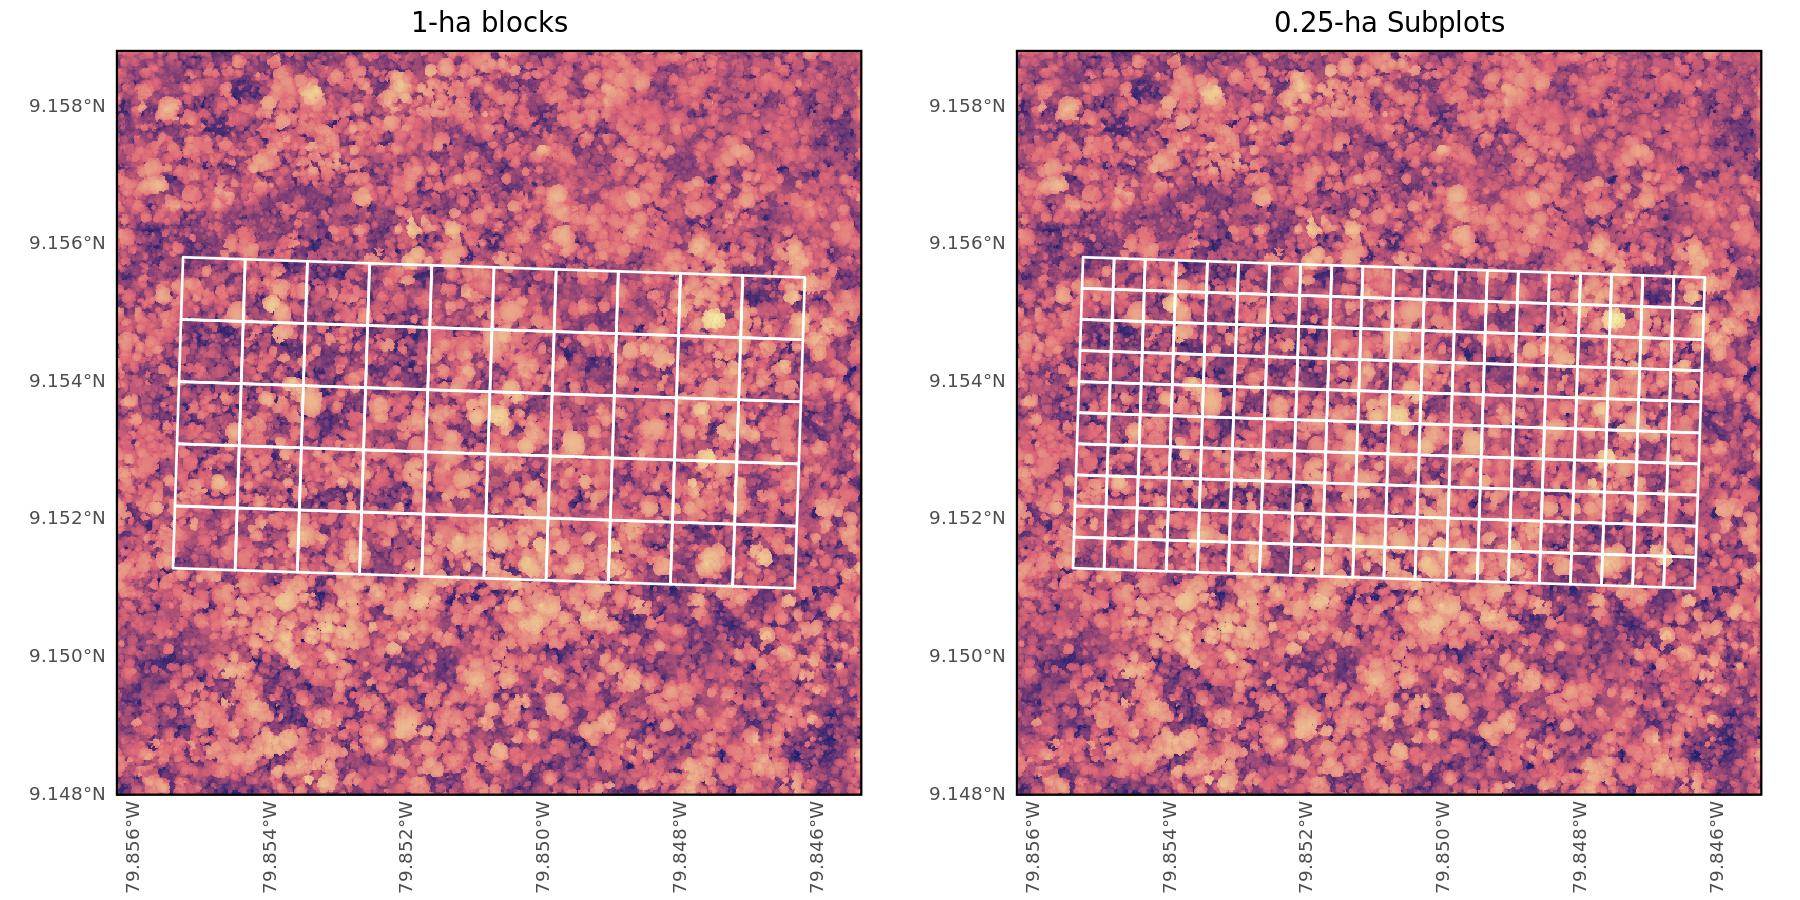

In [19]:
# plot the DTM and CHM for the 50-ha plot

range_DTM = DTM_smooth |> terra::mask(plots) |> minmax()
range_CHM = CHM_smooth |> terra::mask(plots) |> minmax()

suppressMessages({

p1 = ggR(CHM_smooth |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient,
                                na.value = "grey20",
                                limits = c(range_CHM),
                                name = "Canopy height (m)") +
           geom_sf(data = subplots |>
                       filter(NAME == "50-ha plot") |>
                       group_by(NAME_1ha) |>
                       summarize(),
                   color = "white", fill = NA, linewidth = .6) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 11) +
           theme_map  +
             ggtitle("1-ha blocks") +
          theme(plot.title = element_text(hjust = 0.5)) +
            guides(fill = "none")
    
p2 = ggR(CHM_smooth |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient,
                                na.value = "grey20",
                                limits = c(range_CHM),
                                name = "Canopy height (m)") +
           geom_sf(data = filter(subplots, NAME == "50-ha plot"),
                   color = "white", fill = NA, linewidth = .6) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 11) +
           theme_map  +
            ggtitle("0.25-ha Subplots") +
          theme(plot.title = element_text(hjust = 0.5)) +
            guides(fill = "none")

fig = ggarrange(p1, p2,
        ncol = 2, nrow = 1)

})
    
ggsave(plot = fig, 
       filename = "./figures/raster/subplots_50ha.jpeg", 
       device = jpeg,
       width = 12,
       height = 6,
       units = "in",
       dpi = 150,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/subplots_50ha.jpeg") 

**The boundaries of the 50-ha field plot on Barro Colorado Island, and 1-ha and 0.25-ha subplots generated for analysis, outlines shown in white over a canopy height model (CHM).**

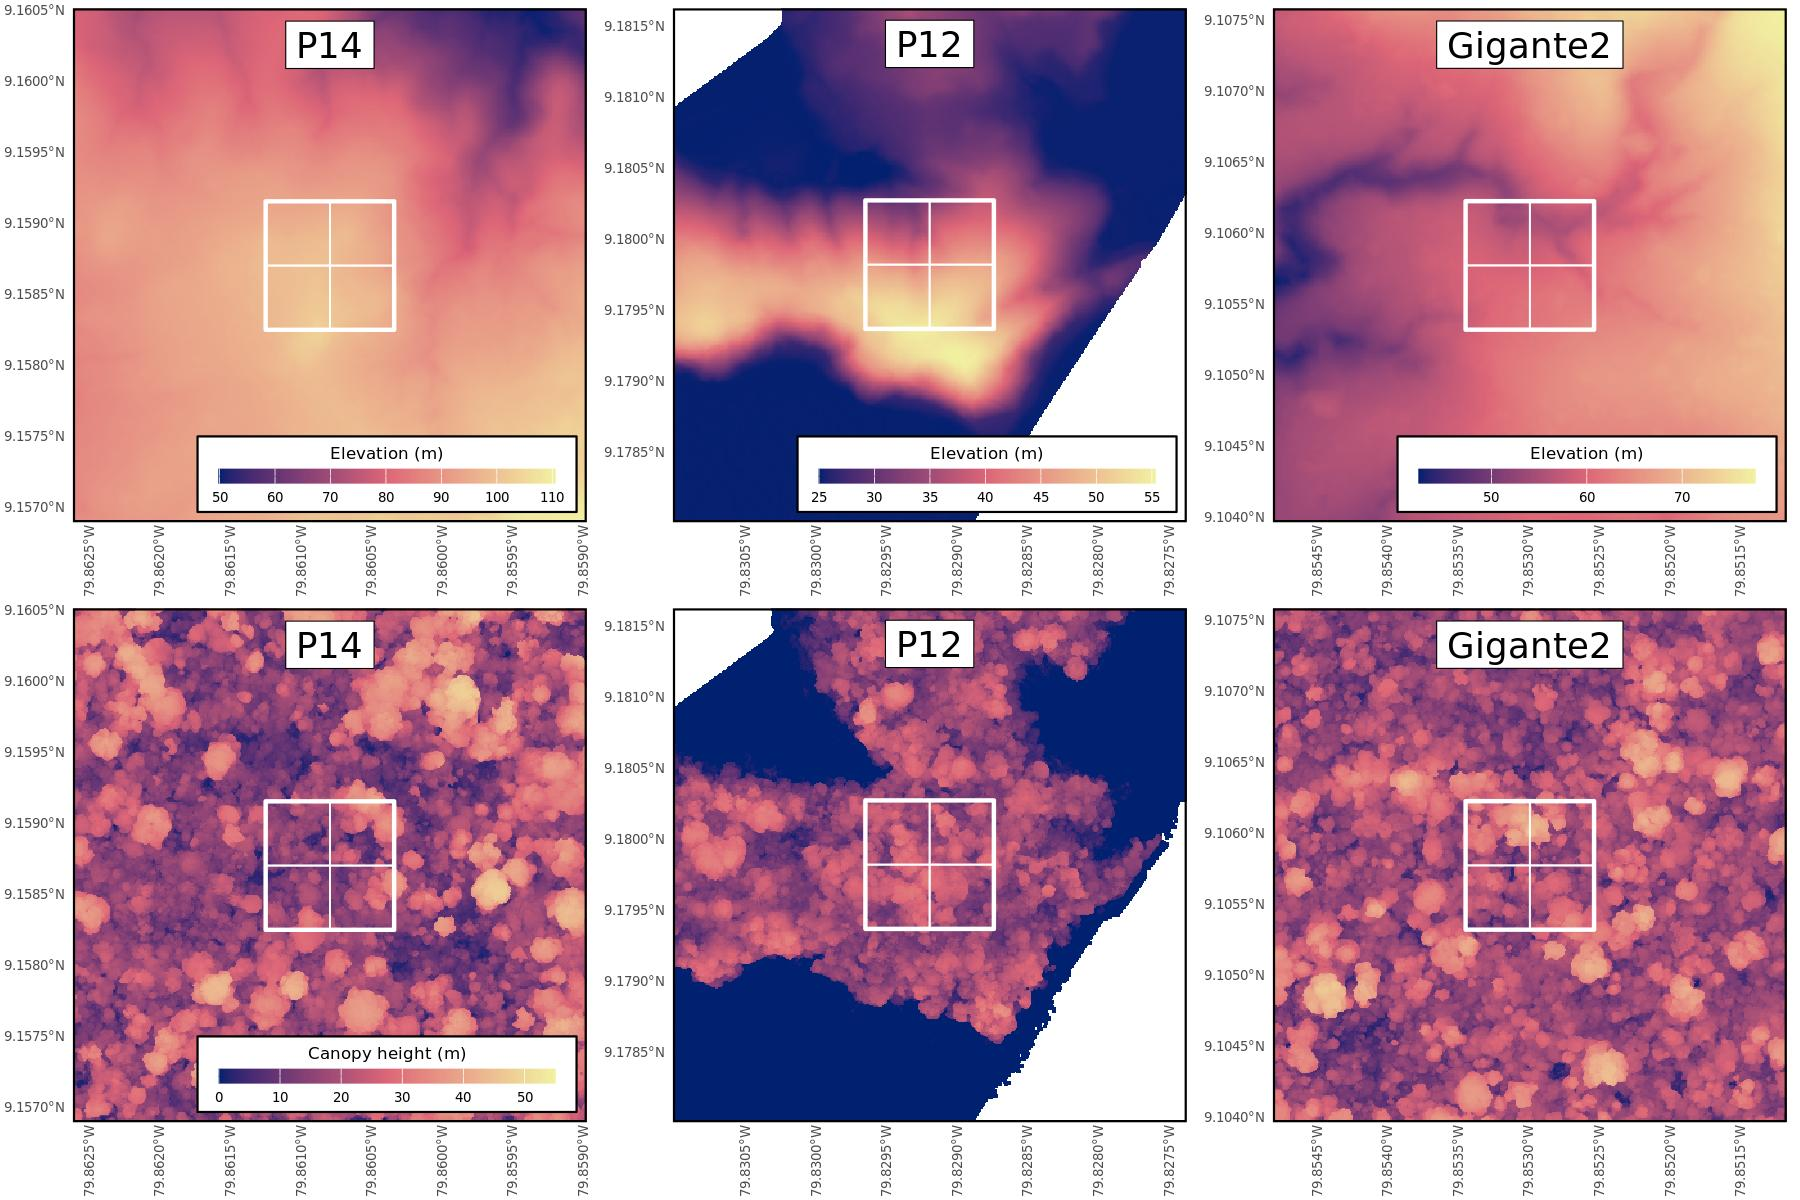

In [20]:
# plot the DTM and CHM for the smaller plots

DTM_list = list()
CHM_list = list()

suppressWarnings(suppressMessages({

for (i in 2:4) {
        
     DTM_list[[i]] = ggR(DTM_smooth |> terra::crop(plots_buf_200m[i,]),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient,
                                na.value = "white",
                                # limits = c(range_DTM),
                                name = "Elevation (m)") +
           geom_sf(data = plots[i,], color = "white", fill = NA, linewidth = 1) +
            geom_sf(data = subplots |> st_crop(plots_buf_200m[i,]), color = "white", fill = NA, linewidth = .4) +
                 geom_sf_label(data = plots_buf_200m[i,],
                            aes(label = NAME),
                            vjust = 1,
                            nudge_y = 185,
                            size = 6, 
                    label.r = unit(0, "pt")) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))

        CHM_list[[i]] = ggR(CHM_smooth |> terra::crop(plots_buf_200m[i,]),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient,
                                na.value = "white",
                                limits = c(range_CHM),
                                name = "Canopy height (m)") +
           geom_sf(data = plots[i,], color = "white", fill = NA, linewidth = 1) +
        geom_sf(data = subplots |> st_crop(plots_buf_200m[i,]), color = "white", fill = NA, linewidth = .4) +
                 geom_sf_label(data = plots_buf_200m[i,],
                            aes(label = NAME),
                            vjust = 1,
                            nudge_y = 185,
                            size = 6, 
                    label.r = unit(0, "pt")) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 8) +
           theme_map +
            guides(fill = guide_colourbar(title.position="top"))
        # })
    
}


fig = ggarrange(DTM_list[[2]], 
                DTM_list[[3]],
                DTM_list[[4]],
                CHM_list[[2]],
                CHM_list[[3]] + guides(fill = "none"), 
                CHM_list[[4]] + guides(fill = "none"),
        ncol = 3, nrow = 2)

}))
    
ggsave(plot = fig, 
       filename = "./figures/raster/plots_DTM_CHM.jpeg", 
       device = jpeg,
       width = 12,
       height = 8,
       units = "in",
       dpi = 150,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/plots_DTM_CHM.jpeg") 


**400-by-400m subets of digital terrain models (DTM) and canopy height models (CHM) for the locations of the 1-ha field plots on Barro Colorado Island. The 1-ha plot boundaries are shown as thicker white lines; 0.25-ha subplot boundaries shown as thin white lines.**

<font color='darkgreen'>**DTM algorithms.** I have used the cloth simulation filter algorithm for ground point classification and smoothed the resulting DTM with a Laplachian filtering in `lasR::pit_fill()`. This seems to be a popular approach. I ran some tests on a few subsets of the dataset and tried a range of parameters; these ones were the best that I could find. However, BCI has extremely high forest cover, dense understory, and complex topography, and the resulting DTM is not perfect. I know that there are modified CSF algorithms published. Do TIG members have preferred approaches to ground classification to recommend? The author of the lasR package is very responsive, so I could contact him to ask about including other algorithms. 
</font>

<font color='darkgreen'>**DTM evaluation.** We are expecting a wide range in ALS penetration over a wider range of forest characteristics, so I would like to have some reproducible way of evaluating DTMs and tuning parameters. 
</font>

### **5.** Produce ALS metrics for field plots.

Now, with field plot boundaries in geospatial form, produce ALS metrics as predictors for each subplot. 

### <font color='grey'> _6_subplots_points
Clip the point clouds to the boundaries of subplot polygons to produce one LAS file representing each subplot. From these point clouds, generate canopy metrics for each subplot, using the same metrics used to generate pixel metrics. 

In [21]:
# _6_subplots_points
# clip the ALS to subplots and extract point-cloud metrics for each subplot
# this step uses lidR

if (length(list.files(dir_list[6])) == 0) {
    plan(multisession, workers = 12L)
    
    # read in the tiles that intersect with the plots
    NORM = readLAScatalog(paste0(root_dir, "/output/_3_normalized_points")) |>
        catalog_intersect(subplots)
    opt_chunk_buffer(NORM) = 0
    opt_laz_compression(NORM) = TRUE
    opt_output_files(NORM) = paste0(root_dir, "/output/_6_subplots_points/{NAME_subplot}")
    opt_progress(NORM) = TRUE
    
    CROWNS = clip_roi(NORM, arrange(subplots, NAME_subplot)) 

    }

<font color='darkgreen'>
The lasR package does not currently support clipping point clouds to polygons, so this step is done using lidR. I do think that it is important to clip out portions of the point cloud representing individual plots and subplots, and that checking these point clouds to make sure they "look right" should be a part of site processing. It is also an important way for scientists who are familiar with the plots to interact with the remote sensing aspect. At some point, I would like to assemble a library of subplot point clouds paired with corresponding photographs and census data from the field.
</font>

In [22]:
# compute metrics for the clipped subplots, at the point cloud level

if (!(file.exists(paste0(root_dir, "/output/subplots_metrics.rds")))) {

    pipeline = 
            lasR::reader_las(filter = "-drop_z_below 0") +
            lasR::summarise(metrics = c("z_p99", "z_mean", "z_cv", "z_above2", "z_above5", "a_mean", "z_count"))
    
    # lasR::summarise does not return any idenitifier to join plots to metrics, and the order in which files are run 
    # is unclear if the pipeline is given a directory pathname.
    # produce a list of files and their corresponding plot names for joining in the next step
    file_list = list.files(paste0(root_dir, "/output/_6_subplots_points"), full.names = TRUE)
    subplot_names = list.files(paste0(root_dir, "/output/_6_subplots_points"), full.names = FALSE) |>
        str_split_i(".la", 1)
    
    
    subs_metrics = exec(pipeline, 
             on = file_list,
             #on = paste0(root_dir, "/output/_6_subplots_points"),
             ncores = 1,
             progress = FALSE)$metrics
    
    CHM_smooth = rast(paste0(root_dir, "/output/_4_CHM_raster/CHM_smooth.tif")) |> crop(metrics_50m)
    #DTM_smooth = rast(paste0(root_dir, "/output/_2_DTM_raster/DTM_smooth.tif")) |> crop(metrics_50m)
    slope = rast(paste0(root_dir, "/output/_5_metrics_raster/slope_1m.tif")) |> crop(metrics_50m)
    aspect = rast(paste0(root_dir, "/output/_5_metrics_raster/aspect_1m.tif")) |> crop(metrics_50m)

    subplots_metrics = subs_metrics |>
        mutate(NAME_subplot = subplot_names) |>
        right_join(subplots, by = "NAME_subplot") |>
        st_as_sf() |>
        # the metrics produced in the previous step, CHM, and DTM
        mutate(
            # number of points / area to get point density
            density = z_count / area,
            # check that subplots meet criteria for analysis, at least 10 pts / m^2
            density_flag = if_else(density > 10, 1, 0),
            # flag subplots meeting FAO definition of forest, cover > 10%
            forest_flag = if_else(z_above2 > .1, 1, 0),
            cover = if_else(z_above5 == 1, z_count / (z_count + 1), z_above5),
            LAI_5m = (-1/.5) * log(1 - cover) * cos(a_mean /180*pi)) %>% 
        # canopy volume (sum of CHM values at 1 m res) for each subplot
        terra::extract(x = CHM_smooth |>
                                tidyterra::rename("Volume" = "focal_min"),
                                      y = .,
                          fun = sum, 
                          na.rm = TRUE, 
                          bind = TRUE) %>% 
        # mean slope for each subplot
        terra::extract(x = slope,
                                      y = .,
                          fun = mean, 
                          na.rm = TRUE, 
                          bind = TRUE) %>%
        # mean aspect for each subplot
        terra::extract(x = aspect |>
                       tidyterra::rename("Aspect" = "lyr.1"),
                                      y = .,
                          fun = mean, 
                          na.rm = TRUE, 
                          bind = TRUE) %>%
    
        # rename variables for plotting
        rename(Z_p99 = z_p99,
               Z_CV = z_cv,
              Slope = slope)
    
    saveRDS(subplots_metrics, paste0(root_dir, "/output/subplots_metrics.rds"))
    
    } else {

    subplots_metrics = readRDS(paste0(root_dir, "/output/subplots_metrics.rds"))
    
    }

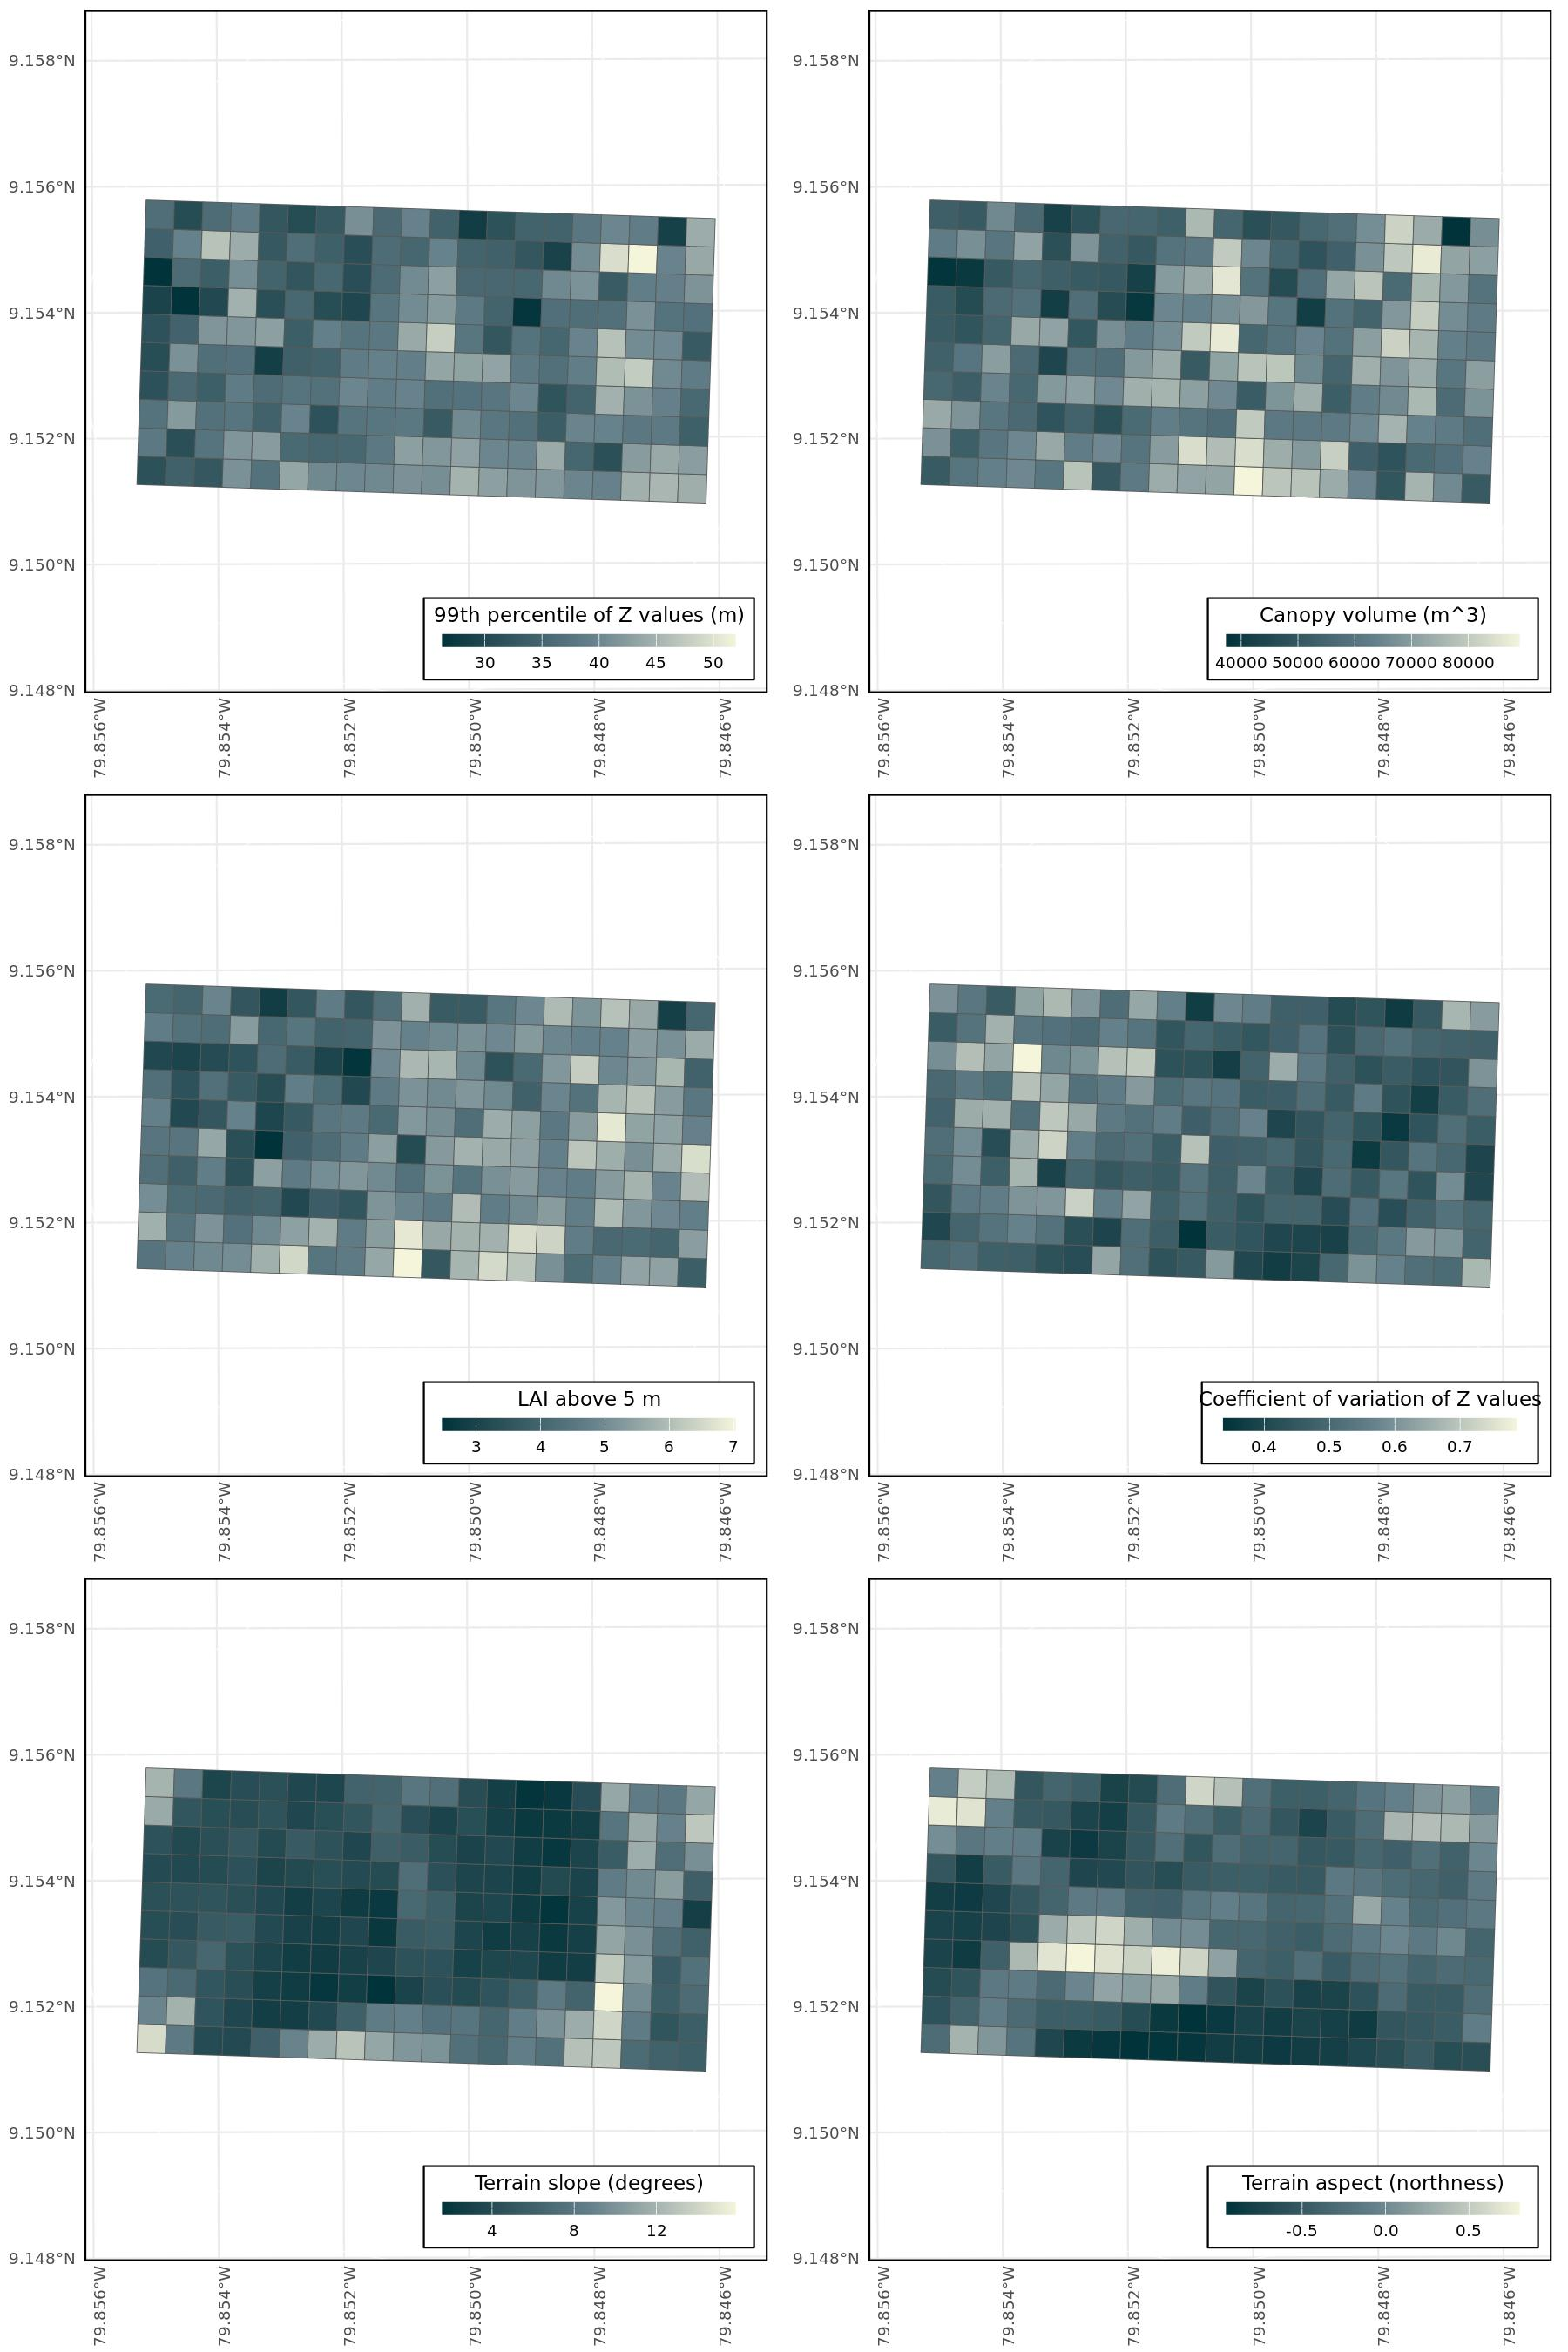

In [23]:
# plot canopy metrics at the subplot level

pred_names = c("Z_p99", "Volume", "LAI_5m", "Z_CV", "Slope", "Aspect")
metrics_list = list()

title_list = c("99th percentile of Z values (m)", 
               "Canopy volume (m^3)",
               "LAI above 5 m",
               "Coefficient of variation of Z values",
               "Terrain slope (degrees)", 
               "Terrain aspect (northness)")

for (i in 1:length(pred_names)) {
        
    metrics_list[[i]] = ggplot() +
        geom_sf(data = st_buffer(plots_buf_200m[1,], 400), color = "white", fill = NA) +
        geom_sf(data = filter(subplots_metrics, NAME == "50-ha plot"), aes(fill = .data[[pred_names[i]]])) +
            scale_fill_gradientn(colors = cols_gradient_metrics,
                                na.value = "grey70",
                                    name = title_list[[i]]) +
                scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
               scale_y_continuous(expand = expansion(mult = c(0, 0))) +
                        theme_bw(base_size = 11) +
                       theme_map +
                      theme(plot.title = element_text(hjust = 0.5)) +
                guides(fill = guide_colourbar(title.position="top"))
    
    #})
}

fig = ggarrange(metrics_list[[1]],
                metrics_list[[2]],
                metrics_list[[3]],
                metrics_list[[4]],
                metrics_list[[5]],
                metrics_list[[6]],
        ncol = 2, nrow = 3)


    
ggsave(plot = fig, 
       filename = "./figures/raster/predictors_subplots.jpeg", 
       device = jpeg,
       width = 12,
       height = 18,
       units = "in",
       dpi = 150,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/predictors_subplots.jpeg") 


**Canopy metrics for 0.25-ha subplots for the 50-ha plot.**

In [24]:
# load the plot census data and apply rotations
# to transofrm plot coordinates to georeferenced coordinates
# Panama plot data from 2023, from Suzanne Lao and Helene Muller-Landau

census = read.csv('./data/Field/request_2023.csv')

suppressWarnings({
    
census_live = census |>
    filter(Status != "dead"
           # filter for plots within the study area, or site
           & PlotName %in% c("bci", "P12", "P14", "gigante2") 
           & PY > 0) |>
    mutate(NAME = case_match(PlotName, 
                             "bci" ~ "50-ha plot",
                             "gigante2" ~ "Gigante2",
                            "P12" ~ "P12",
                            "P14" ~ "P14")) |>
    left_join(plot_rotations |>
                  select(NAME, ORIGIN_X, ORIGIN_Y, theta),
              by = "NAME") |>
    mutate(DBH = as.numeric(DBH),
           X = as.numeric(PX),
           Y = as.numeric(PY),
           # Gigante2 is part of a larger plot, so its coords are offset
           X = if_else(NAME == "Gigante2", X - 300, X),
           Y = if_else(NAME == "Gigante2", Y - 700, Y),
           # apply the rotation to align the census grid to the orientation of the plot
            X_UTM = ORIGIN_X + sqrt(X^2 + Y^2) * cos (atan(Y/X)-theta),
           Y_UTM = ORIGIN_Y + sqrt(X^2 + Y^2) * sin (atan(Y/X)-theta))

census_live_sf = st_as_sf(census_live, coords = c("X_UTM", "Y_UTM"), crs = 32617)

})

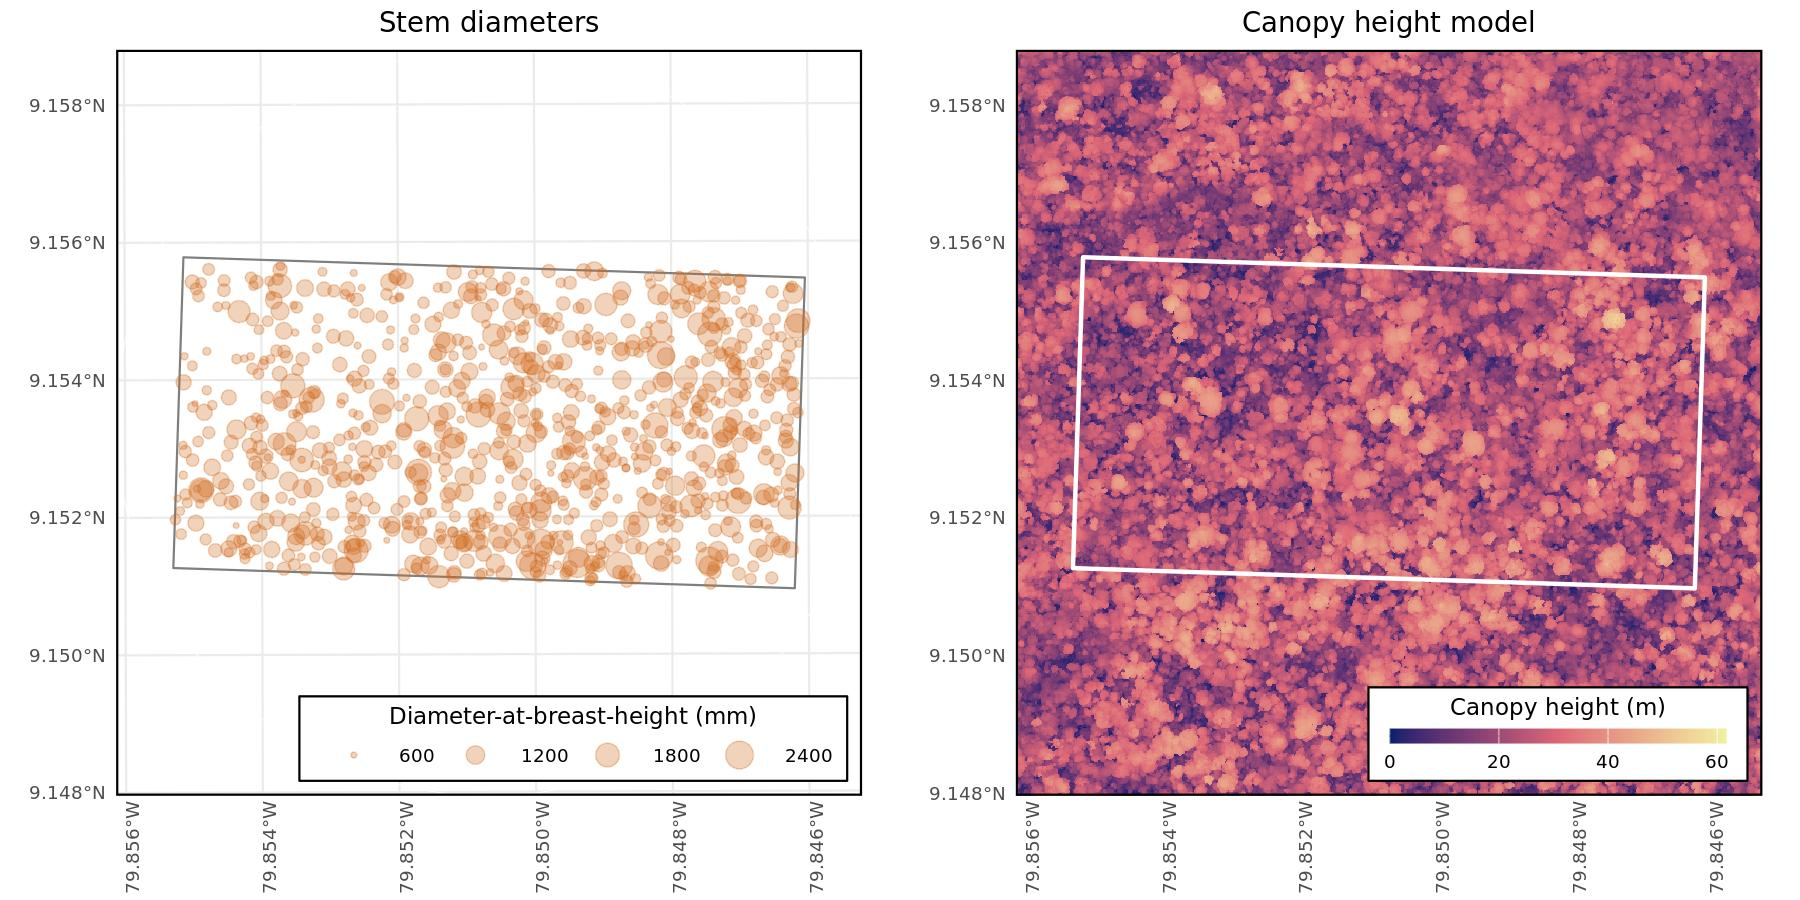

In [25]:
# plot census DBH and the CHM for the 50-ha plot

range_DTM = DTM_smooth |> terra::mask(plots) |> minmax()
range_CHM = CHM_smooth |> terra::mask(plots) |> minmax()

suppressMessages({
    
p1 = ggplot() +
        geom_sf(data = st_buffer(plots_buf_200m[1,], 400), color = "white", fill = NA) +
        geom_sf(data = plots[1,], color = "grey50", fill = NA, linewidth = .5) +
        geom_sf(data = filter(census_live_sf, 
                              NAME == "50-ha plot" & DBH >= 600),
               aes(size = DBH, alpha = DBH), color = "chocolate", alpha = .3) +
            scale_size_continuous(breaks = seq(600, 2400, 600),
                                name = "Diameter-at-breast-height (mm)") +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 11) +
           theme_map  +
             ggtitle("Stem diameters") +
          theme(plot.title = element_text(hjust = 0.5)) +
            guides(size = guide_legend(title.position="top"))

fig = ggarrange(p1, p_CHM,
        ncol = 2, nrow = 1)

})
    
ggsave(plot = fig, 
       filename = "./figures/raster/DBH_CHM_50ha.jpeg", 
       device = jpeg,
       width = 12,
       height = 6,
       units = "in",
       dpi = 150,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/DBH_CHM_50ha.jpeg") 


**Plot census measurements of diamter-at-breast-height (DBH >= 600 mm shown), and a subset of the canopy height model (CHM) for the 50-ha field plot of Barro Colorado Island.**

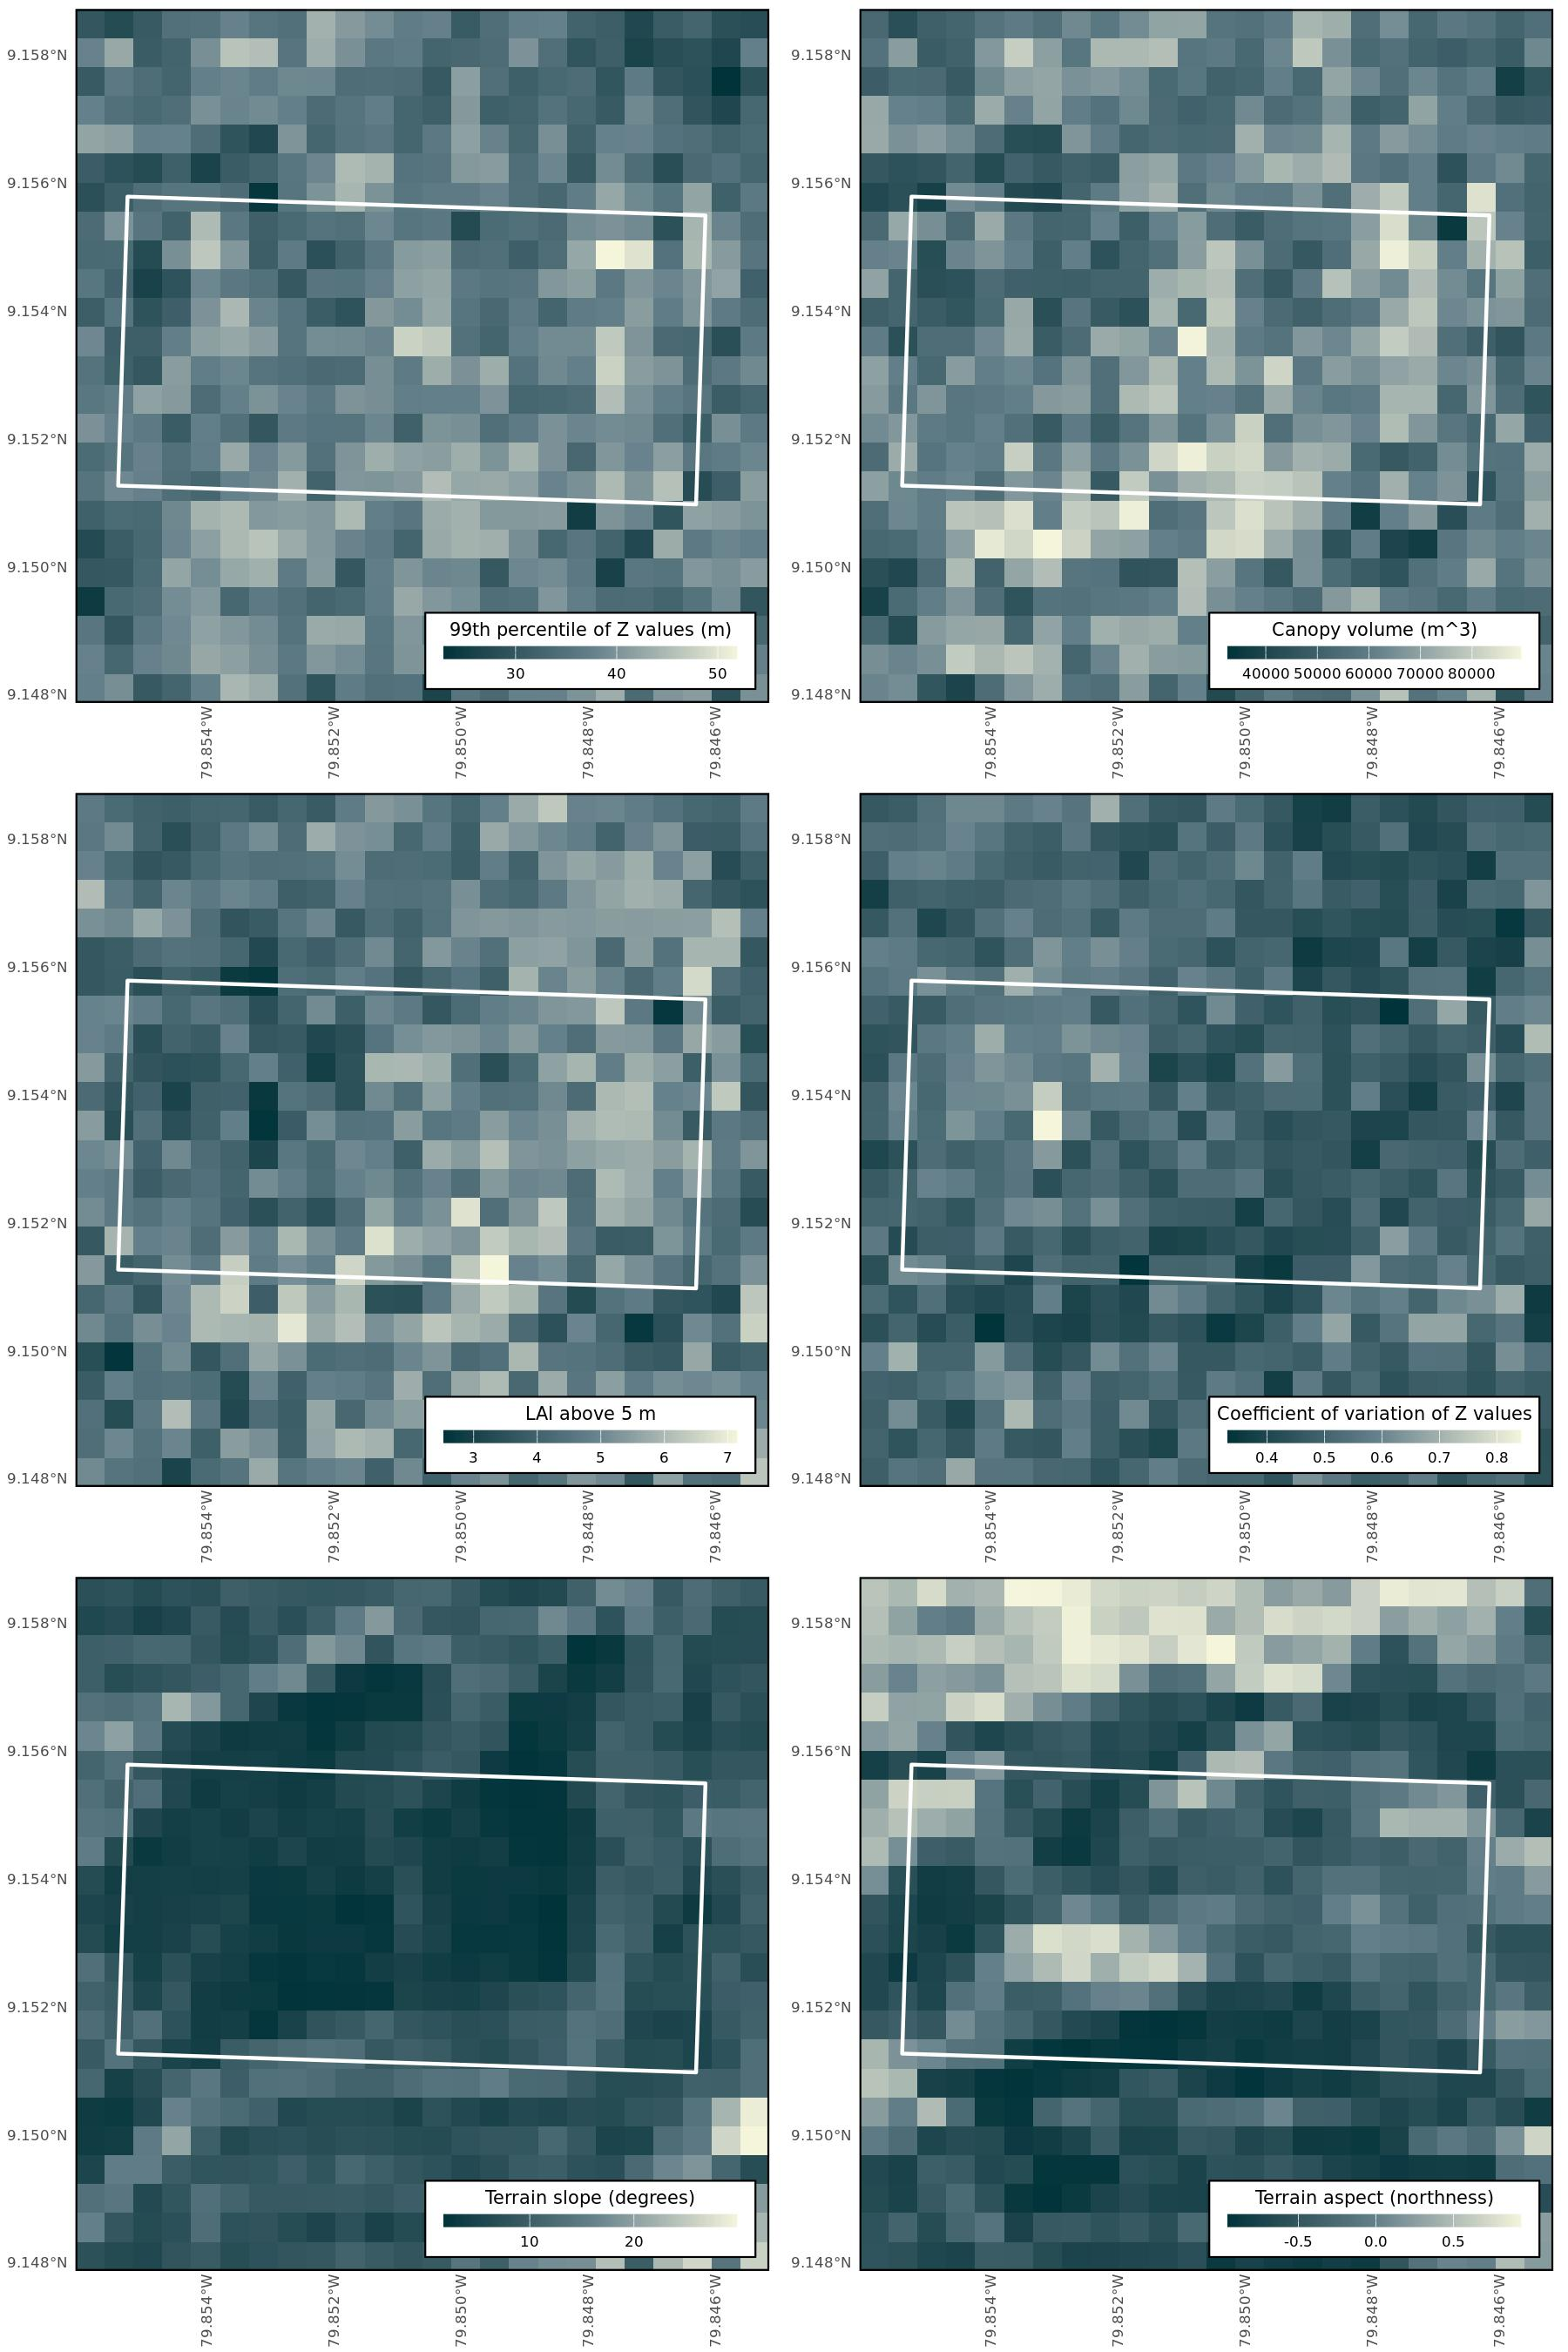

In [26]:
# plot the DTM and CHM for the 50-ha plot

predictors = rast(paste0(root_dir, "/output/_5_metrics_raster/predictors_50m.tif"))

metrics_list_raster = list()

title_list = c("99th percentile of Z values (m)", 
               "Canopy volume (m^3)",
               "LAI above 5 m",
               "Coefficient of variation of Z values",
               "Terrain slope (degrees)", 
               "Terrain aspect (northness)")

for (i in 1:nlyr(predictors)) {


    suppressMessages({
        
    metrics_list_raster[[i]] = ggR(predictors[[i]] |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
                   geom_raster = TRUE) +
                scale_fill_gradientn(colors = cols_gradient_metrics,
                                    na.value = "grey70",
                                    # limits = c(range_DTM),
                                    name = title_list[[i]]) +
               geom_sf(data = plots[1,], color = "white", fill = NA, linewidth = 1) +
                scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
               scale_y_continuous(expand = expansion(mult = c(0, 0))) +
                theme_bw(base_size = 10) +
               theme_map +
                guides(fill = guide_colourbar(title.position="top"))
    
    })
}

fig = ggarrange(metrics_list_raster[[1]],
                metrics_list_raster[[2]],
                metrics_list_raster[[3]],
                metrics_list_raster[[4]],
                metrics_list_raster[[5]],
                metrics_list_raster[[6]],
        ncol = 2, nrow = 3)


    
ggsave(plot = fig, 
       filename = "./figures/raster/predictors_50ha.jpeg", 
       device = jpeg,
       width = 12,
       height = 18,
       units = "in",
       dpi = 150,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/predictors_50ha.jpeg") 


**ALS metrics at 50-m resolution for the 50-ha plot.**


### **6.** Quantify live woody aboveground biomass from field data.

To calculate AGB density from field-measured DBH, first use allometric equations to estimate wood density and height for each live stem based on its taxonomy and DBH. Then, compute aboveground biomass for each stem and sum all stem values within each 0.25-ha subplot. 

<font color='darkgreen'>
There will be another GEO-TREES post-doc hired soon to work on plot data. I imagine that we will work together to refine this part of the workflow. For now, I have made simple caluclations of biomass using the BIOMASS package. 
</font>

In [27]:
# convert census measurements to georefenced biomass estimates for each stem, 
# then aggregate to subplot AGB and AGB density

suppressMessages({

# get the average coordinates for the whole site to estimate AGB from DBH
COORD = census_live_sf |>
    st_transform(4326) |>
    st_coordinates() |> 
    as_tibble() |>
    summarize_all(mean)

# use Chave's equations to estimate AGB for each tree of each taxon
census_AGB = census_live_sf |> 
    mutate(Density = (getWoodDensity(genus = Genus,
                            SpeciesName,
                            family = Family,
                            region = "SouthAmericaTrop"))$meanWD,
           # biomass in Mg
          AGB = computeAGB(D = DBH/10,
                           WD = Density,
                           H = NULL, 
                           coord = COORD, Dlim = NULL)) |>
    st_join(dplyr::select(subplots, NAME_subplot, area, geometry))

census_AGB_by_subplot = census_AGB |>
    group_by(NAME_subplot, area) |>
    summarize(AGB_sum = sum(AGB, na.rm = TRUE)) |>
           # area in m^2 * 0.0001 = area in ha 
           mutate(AGB_per_ha = AGB_sum / (area * 0.0001)) |>
    st_drop_geometry()

subplots_AGB = subplots |>
    left_join(census_AGB_by_subplot, by = c("area", "NAME_subplot")) |>
    left_join(readRDS(paste0(root_dir, "/output/subplots_metrics.rds")) |>
              st_as_sf() |>
             st_drop_geometry() |>
             dplyr::select(NAME_subplot, forest_flag, density_flag, 
                           Z_p99, Volume, LAI_5m, Z_CV, Slope, Aspect))

})

saveRDS(subplots_AGB, paste0(root_dir, "/output/subplots_AGB.rds"))


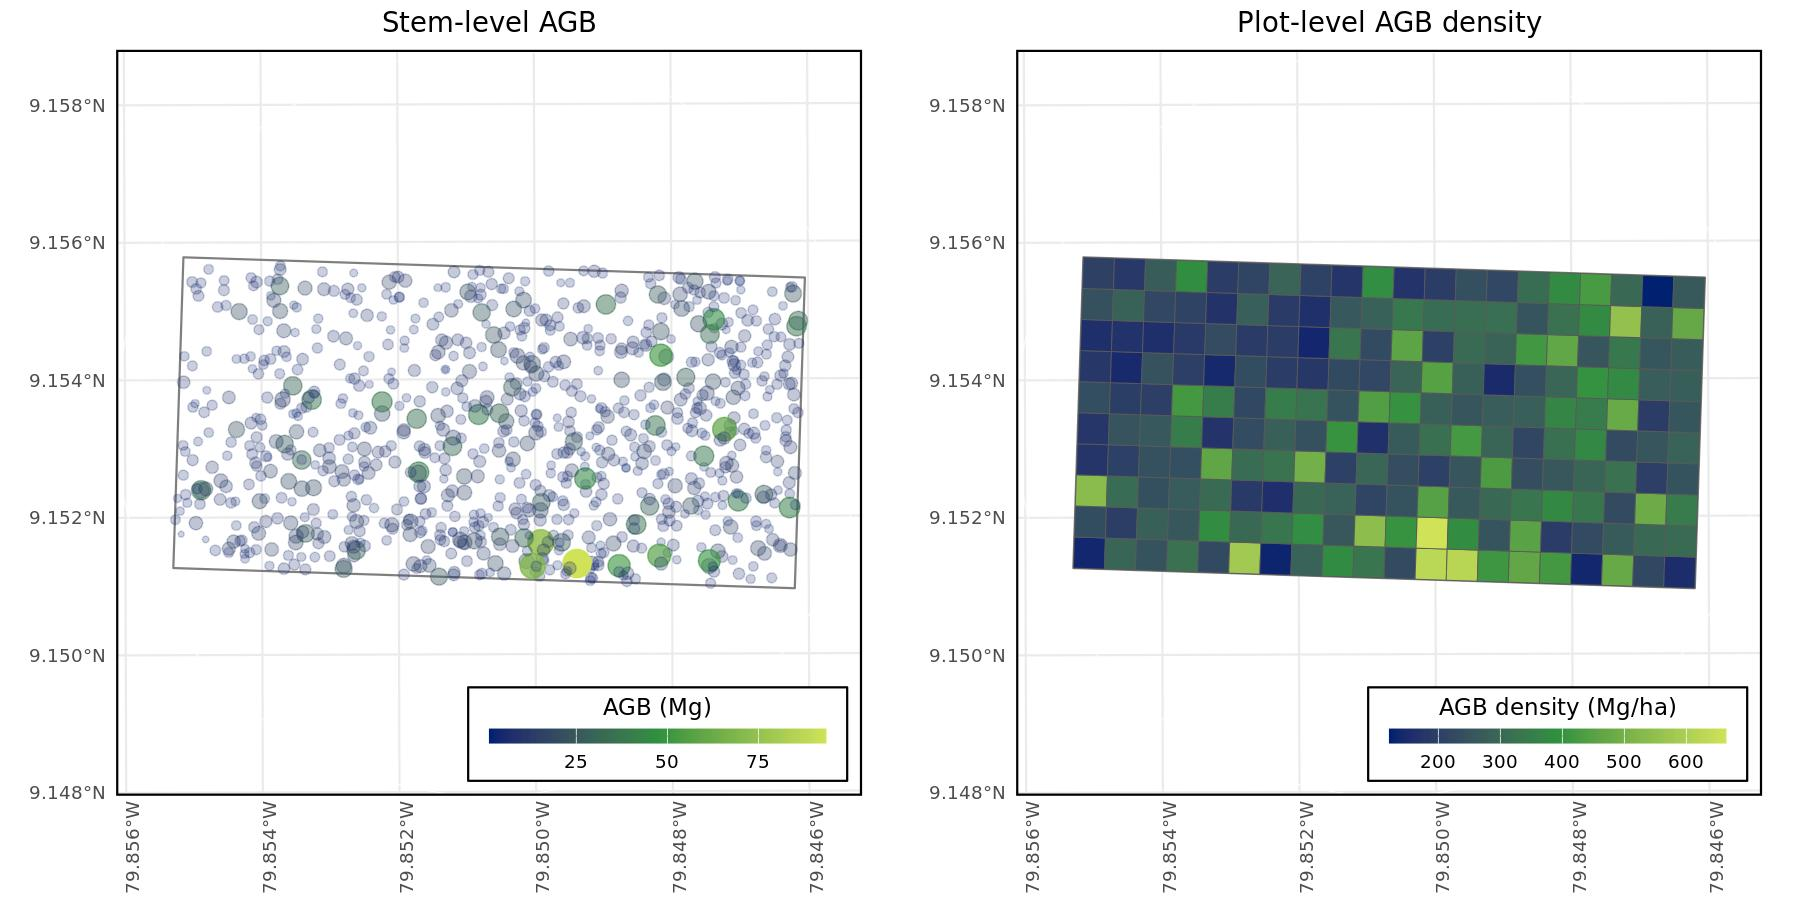

In [28]:
# plot subplot AGB density and the CHM for the 50-ha plot

suppressMessages({
    
p_AGB_stem = ggplot() +
        geom_sf(data = st_buffer(plots_buf_200m[1,], 400), color = "white", fill = NA) +
        geom_sf(data = plots[1,], color = "grey50", fill = NA, linewidth = .5) +
        geom_sf(data = filter(census_AGB, 
                              NAME == "50-ha plot" & DBH >= 600),
               aes(size = AGB, color = AGB, alpha = AGB)) +
        scale_alpha_continuous(range = c(.2, 1), guide = "none") +
            scale_size_continuous(breaks = seq(600, 2400, 600),
                                name = "Diameter-at-breast-height (mm)",
                                 guide = "none") +
            scale_color_gradientn(colors = cols_gradient_biomass,
                                na.value = "grey70",
                                #limits = c(range_AGB),
                                name = "AGB (Mg)") +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 11) +
           theme_map  +
             ggtitle("Stem-level AGB") +
          theme(plot.title = element_text(hjust = 0.5)) +
            guides(color = guide_colorbar(title.position="top"))
    
p_AGB_subplots = ggplot() +
        geom_sf(data = st_buffer(plots_buf_200m[1,], 400), color = "white", fill = NA) +
        geom_sf(data = plots[1,], color = "grey50", fill = NA, linewidth = .5) +
        geom_sf(data = filter(subplots_AGB, 
                              NAME == "50-ha plot"),
               aes(fill = AGB_per_ha)) +
        scale_fill_gradientn(colors = cols_gradient_biomass,
                                na.value = "grey70",
                                #limits = c(range_AGB),
                                name = "AGB density (Mg/ha)") +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 11) +
           theme_map  +
             ggtitle("Plot-level AGB density") +
          theme(plot.title = element_text(hjust = 0.5)) +
            guides(fill = guide_colorbar(title.position="top"))


fig = ggarrange(p_AGB_stem, p_AGB_subplots,
        ncol = 2, nrow = 1)

})
ggsave(plot = fig, 
       filename = "./figures/raster/AGB_CHM_50ha.jpeg", 
       device = jpeg,
       width = 12,
       height = 6,
       units = "in",
       dpi = 150,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/AGB_CHM_50ha.jpeg")


**Individual-tree AGB from plot census measurements (DBH >= 600 mm shown), and AGB density for 0.25-ha subplots within the 50-ha field plot on Barro Colorado Island.**


### **7.** Build models of AGB from ALS metrics.

AGB density reference maps are generated from emperical relationships between plot AGB density and ALS metrics. Fit canidate models to compare their predictions, selected from different approaches:
(i) A Random Forest model,
(ii) Backwards stepwise linear regression.

<font color='darkgreen'>**Candidate model selection.** The following two models, a simple linear regression and a Random Forests with six predictors, are examples to demonstrate the framework. I welcome suggestions from the TIG of approaches that you would like to see represented as candidate models. We are aiming for a handful of defensible approaches to compare. 
</font>

In [29]:
# assemble data frame for modeling

preds_50m = rast(paste0(root_dir, "/output/_5_metrics_raster/predictors_50m.tif"))
subplots_AGB_df = readRDS(paste0(root_dir, "/output/subplots_AGB.rds"))


AGB_df = subplots_AGB |>
    st_drop_geometry()

# fit a random forests model
rf = randomForest(formula = AGB_per_ha ~ Z_p99 +
                                  Volume +
                                  LAI_5m + 
                                  Z_CV + 
                                  Slope + 
                                  Aspect, 
                    data = AGB_df, mtry = 3)

# Backward stepwise regression
# the selected model is a simple univariate model, using canopy volume
lin = step(lm(AGB_per_ha ~ Z_p99 +
                                  Volume +
                                  LAI_5m + 
                                  Z_CV + 
                                  Slope + 
                                  Aspect, 
                          data = AGB_df), 
                       direction = "backward", trace = 0)


In [30]:
AGB_mods = AGB_df %>%
    tidyr::nest() %>%
    # fit the candidate models as list columns with purrr
    mutate(`Random Forest` = purrr::map(data, 
                           ~randomForest(formula = AGB_per_ha ~ 
                                              Z_p99 +
                                              Volume +
                                              LAI_5m + 
                                              Z_CV + 
                                              Slope + 
                                              Aspect,
                                              data = ., mtry = 3)),
           `Linear regression` = purrr::map(data, 
                           ~lm(formula = AGB_per_ha ~ 
                                              Volume,
                                              data = .))) %>%
    pivot_longer(`Random Forest`:`Linear regression`, names_to = "model_name", values_to = "model") %>%
    mutate(preds = map2(data, model, modelr::add_predictions)) %>%
      mutate(preds = map(preds, dplyr::select, pred)) %>%
      mutate(resids = map2(data, model, modelr::add_residuals)) %>%
      mutate(resids = map(resids, dplyr::select, resid)) %>%
     # mutate(glance = map(model, broom::glance))  %>% 
      # #mutate(rmse_halfnorm = map(model, qpcR::RMSE)) %>%
        dplyr::select(-model) %>%
      unnest(c(data, preds, resids))

AGB_mods_eval = AGB_mods %>%
    group_by(model_name) %>%
    summarize(x_min = min(pred),
              y_max = max(AGB_per_ha),
              Bias = round(mean(resid), 2),
              MAE = round(mean(abs(resid)), 2),
              RMSE = round(sqrt(mean(resid^2)), 2))


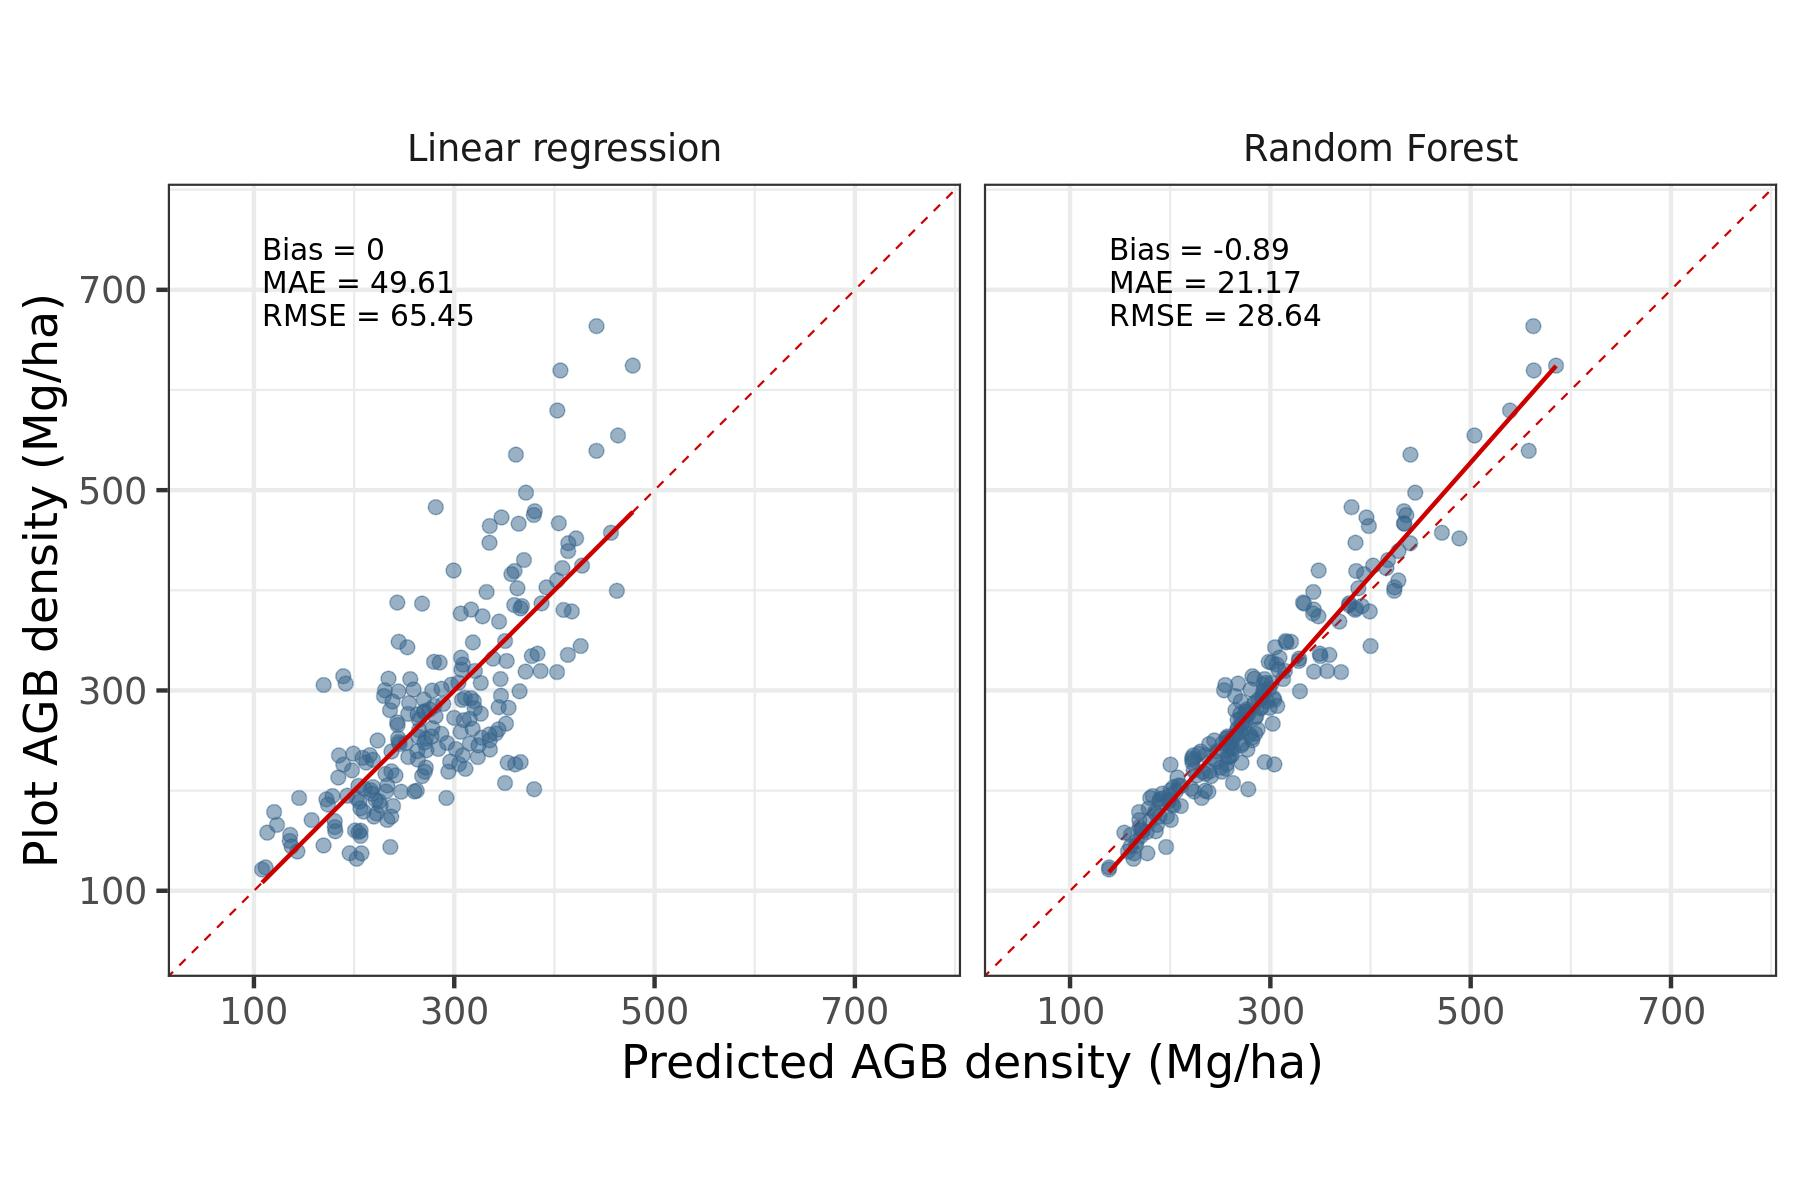

In [31]:
# plot the predictions vs. measured AGB densities

fig = AGB_mods |>
    ggplot(aes(x = pred, y = AGB_per_ha)) +
            geom_abline(slope = 1, linetype = "dashed", color="red3") +
            geom_point(size = 3, color = "steelblue4", alpha = .5) +
            geom_smooth(method = "lm", formula = 'y ~ x', se = FALSE, color = "red3") + 
            geom_text(data = AGB_mods_eval,
                      aes(x = x_min,
                      y = y_max,
                      label = paste0('Bias = ', Bias)),  
                        size = 5,  
                        parse = FALSE,  
                        vjust = -3,  
                        hjust = 0) +
            geom_text(data = AGB_mods_eval,
                      aes(x = x_min,
                      y = y_max,
                      label = paste0('MAE = ', MAE)),  
                        size = 5,  
                        parse = FALSE,  
                        vjust = -1.5,  
                        hjust = 0) +
            geom_text(data = AGB_mods_eval,
                      aes(x = x_min,
                      y = y_max,
                      label = paste0('RMSE = ', RMSE)),  
                        size = 5,  
                        parse = FALSE,  
                        vjust = 0,  
                        hjust = 0) +
            theme_bw(base_size = 22) +
            scale_x_continuous(limits = c(50, 770), breaks = seq(100, 700, 200)) +
            scale_y_continuous(limits = c(50, 770), breaks = seq(100, 700, 200)) +
            theme(aspect.ratio = 1,
                 strip.background = element_blank()) +
            coord_fixed(ratio = 1) +
            labs(x = "Predicted AGB density (Mg/ha)",
                 y = "Plot AGB density (Mg/ha)") +
    
            facet_grid(. ~ model_name)

ggsave(plot = fig, 
       filename = "./figures/models/AGB_predictions.jpeg", 
       device = jpeg,
       width = 12,
       height = 8,
       units = "in",
       dpi = 150,
       bg = "white",
      create.dir = TRUE)

IRdisplay::display_jpeg(file = "./figures/models/AGB_predictions.jpeg") 


**Goodness-of-fit for model predictions of AGB density and AGB density from field census data, for 0.25-ha subplots.**

### **8.** Validate the models.

Ideal models for AGB prediction should be highly generalizable; they should predict AGB density values reasonably well across spatially varied forest characteristics. An overfitted model, which performs well on field plot data but has high uncertainty, is not an appropriate choice for AGB reference map generation. Employ a spatial cross-validation approach to estimate the models' performance on forest not represented in the training data. This approach refits each model, leaving out one hectare of field plot data at a time (four subplots). It is equivalent to a leave-k-out cross validation, where k is equal to four contiguous subplots. 

<font color='darkgreen'>**Cross validation.** Cross validation is another area where I request discussion from the TIG. This spatially stratified leave-one-out approach is here for demonstration, but we will need a robust framework for assessing model predictions. Importantly, many sites will have huge ranges of AGB that are only partially captured by field plots. And the coverage of field plots will vary widely by site. We need to quantify uncertainties carefully.
</font>

In [32]:
# variable-wise cross validation function

crossv_strat =
  function (data, var) {
    n <- nrow(data)
    folds = data[var][[1]]
    idx <- seq_len(n)
    fold_idx <- split(idx, folds)
    fold <- function(test) {
      list(train = modelr::resample(data, setdiff(idx, test)), 
           test = modelr::resample(data, test))
    }
    cols <- purrr::transpose(purrr::map(fold_idx, fold))
    tibble::as_tibble(cols)
  }



In [33]:
# plot the predictions vs. measured AGB densities

AGB_mods_cv = subplots_AGB %>%
    as_tibble() |> 
    drop_na() |>
    #rsample::group_vfold_cv(group = "cluster") #|>
    crossv_strat(var = 'NAME_1ha') %>%
    #fit each model with the training data
    mutate(
        `Random Forest` = purrr::map(train, 
                           ~randomForest(formula = AGB_per_ha ~ 
                                              Z_p99 +
                                              Volume +
                                              LAI_5m + 
                                              Z_CV + 
                                              Slope + 
                                              Aspect,
                                              data = ., mtry = 3)),
           `Linear regression` = purrr::map(train, 
                           ~lm(formula = AGB_per_ha ~ 
                                              Volume,
                                              data = .))
    ) %>%
    pivot_longer(cols = c(`Random Forest`, `Linear regression`), names_to = "model_name", values_to = "model") %>%
   # mutate(resid = map2(test, model, ~ modelr::add_residuals(as.data.frame(.x), .y)))
    mutate(preds = map2(test, model, ~modelr::add_predictions(as.data.frame(.x), .y))) %>%
    mutate(preds = map(preds, dplyr::select, pred)) %>%
    mutate(resids = map2(test, model, ~modelr::add_residuals(as.data.frame(.x), .y))) %>%
    mutate(resids = map(resids, dplyr::select, resid)) %>%
    mutate(data = map(test, ~as.data.frame(.x))) %>%
    unnest(c(model_name, data, preds, resids))

AGB_mods_eval_cv = AGB_mods_cv %>%
    group_by(model_name) %>%
    summarize(x_min = min(pred),
              y_max = max(AGB_per_ha),
              Bias = round(mean(resid), 2),
              MAE = round(mean(abs(resid)), 2),
              RMSE = round(sqrt(mean(resid^2)), 2))


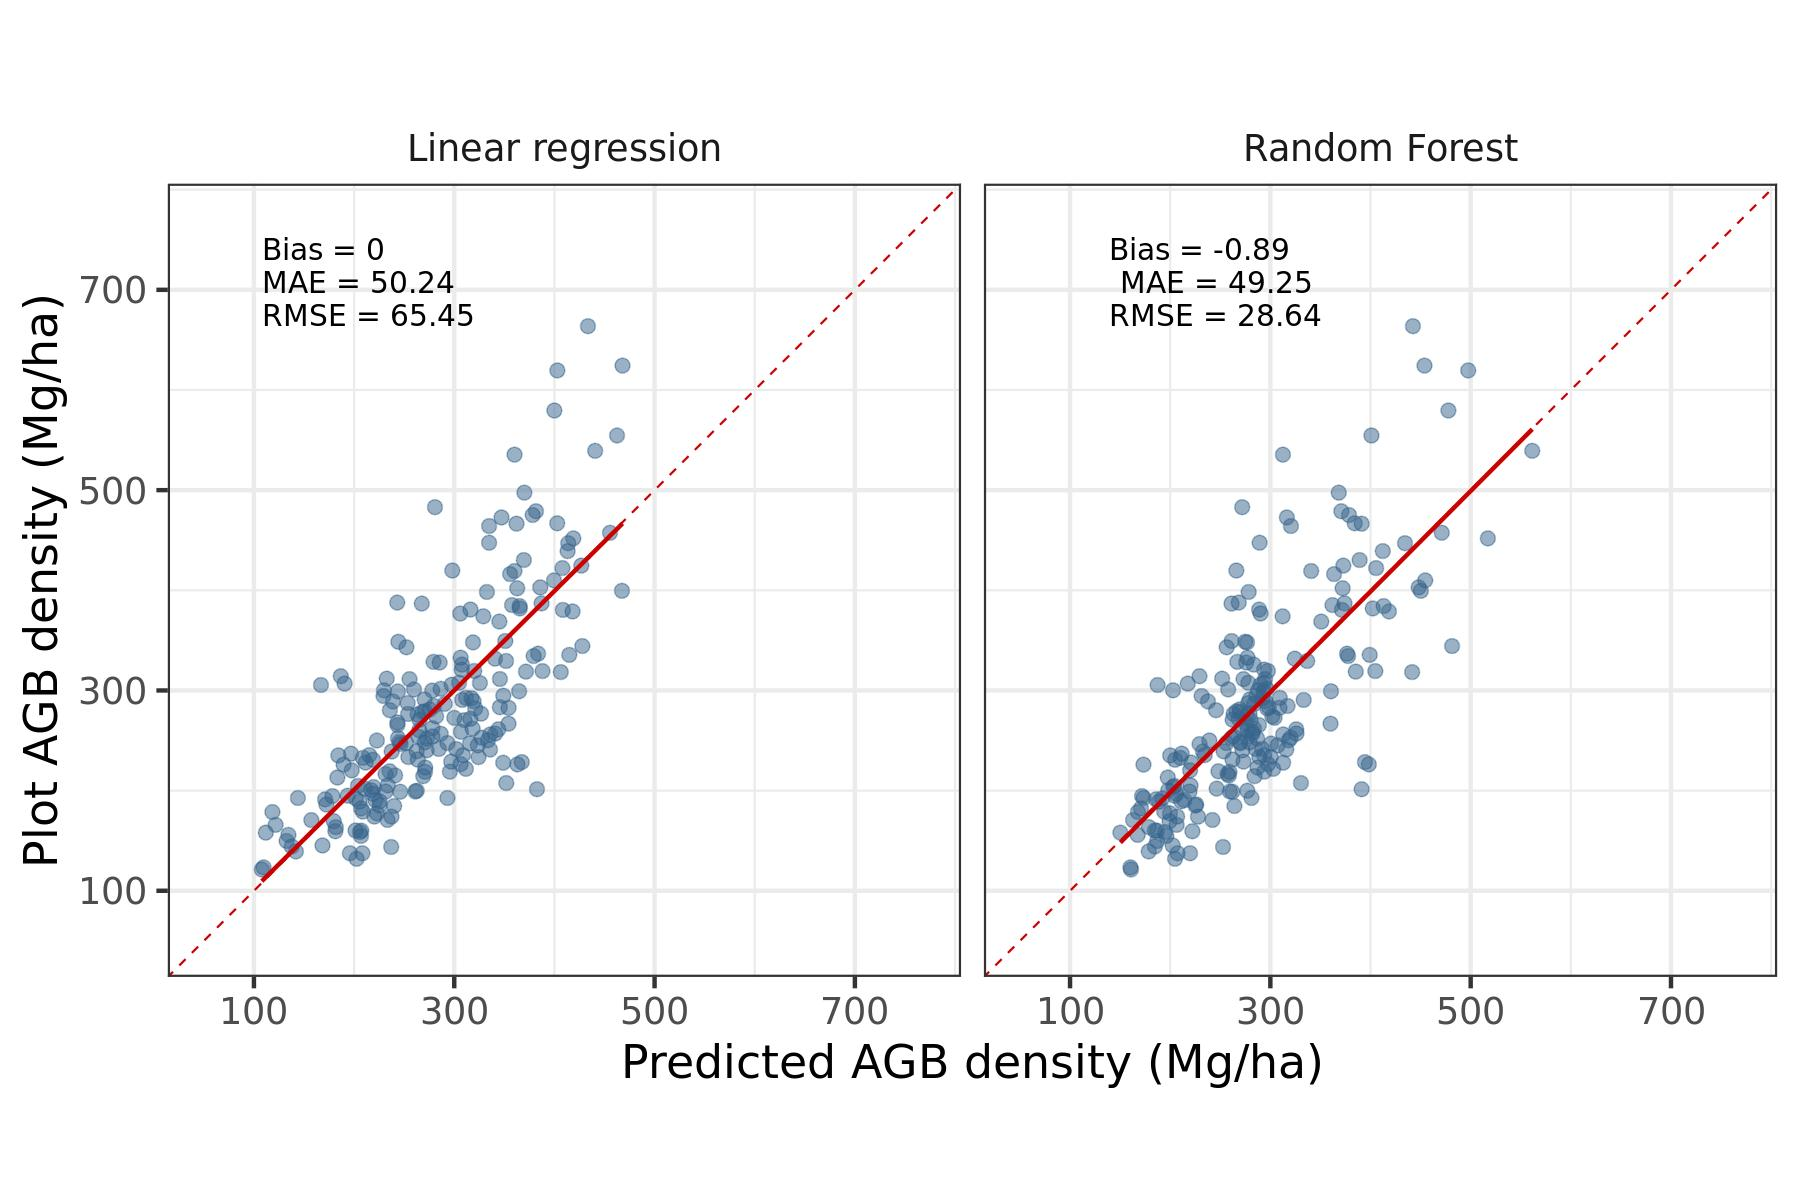

In [34]:
# plot the cross-validation predictions vs. measured AGB densities

fig = AGB_mods_cv |>
    ggplot(aes(x = pred, y = AGB_per_ha)) +
            geom_abline(slope = 1, linetype = "dashed", color="red3") +
            geom_point(size = 3, color = "steelblue4", alpha = .5) +
            geom_smooth(method = "lm", formula = 'y ~ x', se = FALSE, color = "red3") +
            geom_text(data = AGB_mods_eval,
                      aes(x = x_min,
                      y = y_max,
                      label = paste0('Bias = ', Bias)),  
                        size = 5,  
                        parse = FALSE,  
                        vjust = -3,  
                        hjust = 0) +
            geom_text(data = AGB_mods_eval_cv,
                      aes(x = x_min,
                      y = y_max,
                      label = paste0('MAE = ', MAE)),  
                        size = 5,  
                        parse = FALSE,  
                        vjust = -1.5,  
                        hjust = 0) +
            geom_text(data = AGB_mods_eval,
                      aes(x = x_min,
                      y = y_max,
                      label = paste0('RMSE = ', RMSE)),  
                        size = 5,  
                        parse = FALSE,  
                        vjust = 0,  
                        hjust = 0) +
            theme_bw(base_size = 22) +
            scale_x_continuous(limits = c(50, 770), breaks = seq(100, 700, 200)) +
            scale_y_continuous(limits = c(50, 770), breaks = seq(100, 700, 200)) +
            theme(aspect.ratio = 1,
                 strip.background = element_blank()) +
            coord_fixed(ratio = 1) +
            labs(x = "Predicted AGB density (Mg/ha)",
                 y = "Plot AGB density (Mg/ha)") +
    
            facet_grid(. ~ model_name)

ggsave(plot = fig, 
       filename = "./figures/models/AGB_cross_validation.jpeg", 
       device = jpeg,
       width = 12,
       height = 8,
       units = "in",
       dpi = 150,
       bg = "white",
      create.dir = TRUE)

IRdisplay::display_jpeg(file = "./figures/models/AGB_cross_validation.jpeg") 


**Goodness-of-fit for spatially stratified leave-k-out cross validation; model predictions of AGB density and AGB density from field census data, for 0.25-ha subplots.**

<font color='darkgreen'> While the Random Forest model shows a much better fit than the regression model on plot-measured AGB, their performance is more similar on cross-validation data, suggesting overfitting in the Random Forests model.
</font>

In [35]:

predictors = rast(paste0(root_dir, "/output/_5_metrics_raster/predictors_50m.tif")) 

# apply the model to all cells of the raster of predictors
AGB_predict = c(predict(predictors, lin), predict(predictors, rf))
names(AGB_predict) = c("Random Forest", "Linear regression")

# # create one raster with plot AGB and model predictions
# AGB_compare = c(AGB_mod, AGB_predict) |>
#     as_tibble() |>
#     drop_na() |>
#     mutate(Plot_size = if_else(Plot == "50-ha plot", Plot, "1-ha plots"))
# plot(AGB_predict$`Linear regression`)
# plot(predictors$Volume)

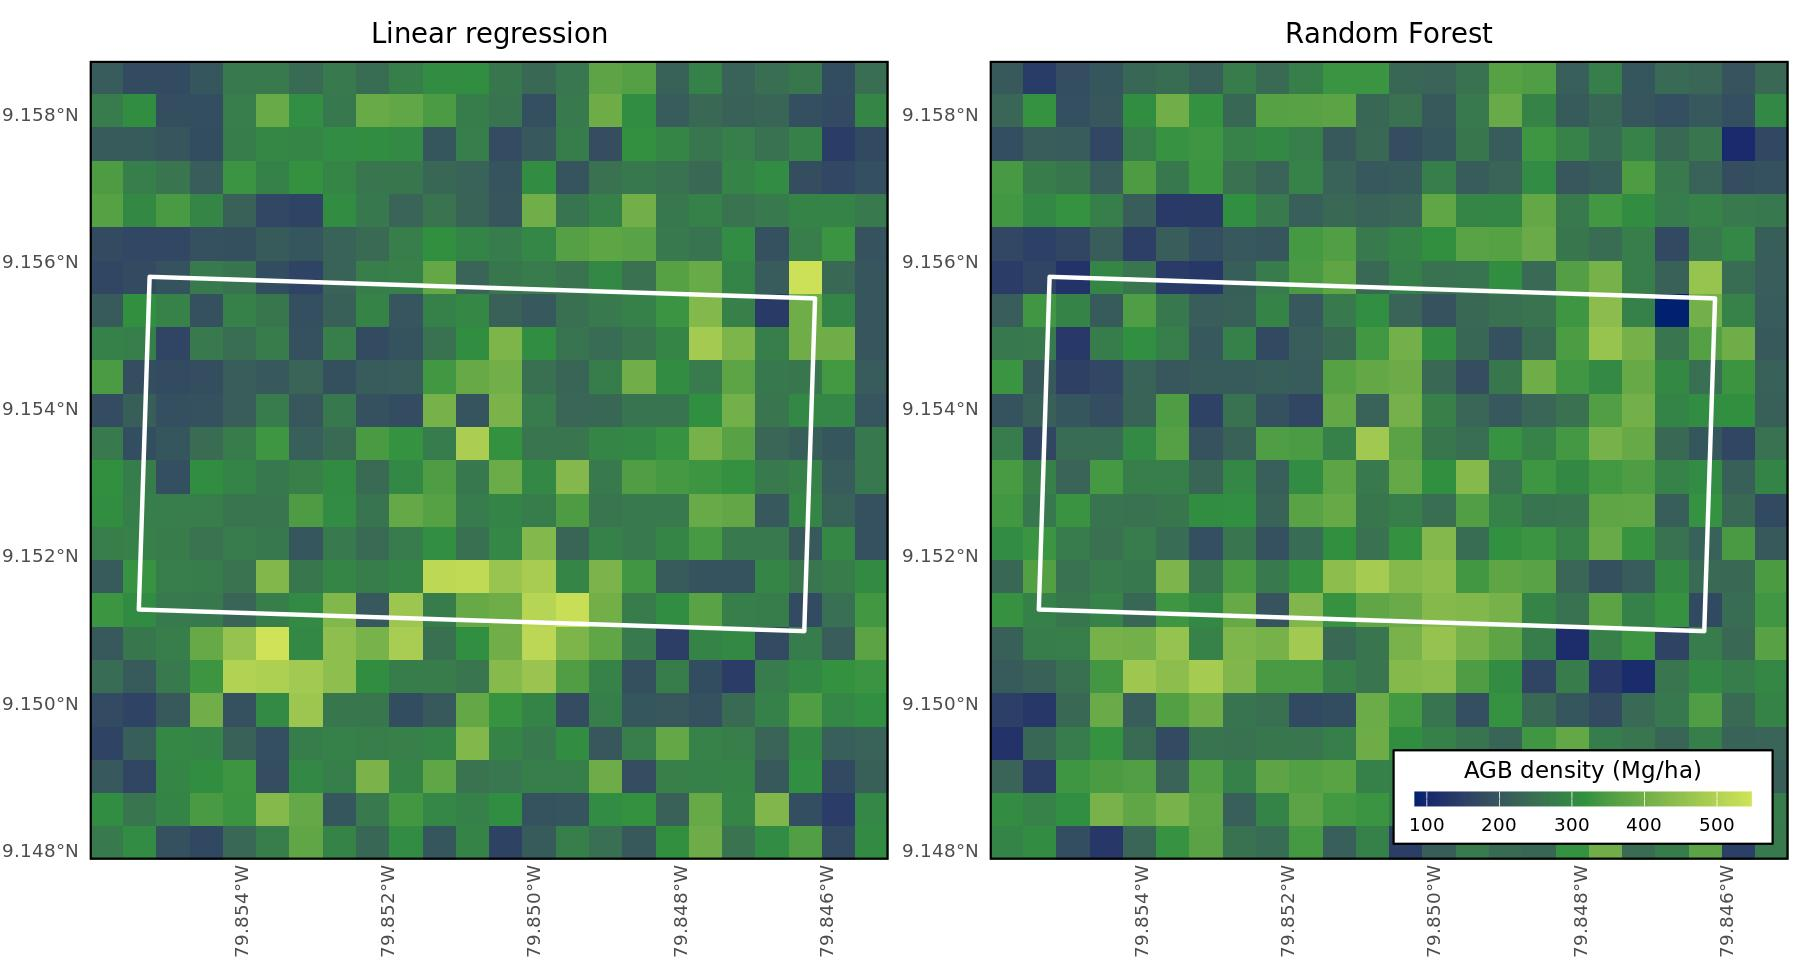

In [36]:
# plot the DTM and CHM for the 50-ha plot

range_AGB = AGB_predict |> terra::mask(st_buffer(plots_buf_200m[1,], 400)) |> minmax()
range_AGB = c(min(range_AGB[,1]), max(range_AGB[,2]))


suppressMessages({
    
p_AGB_raster = ggR(AGB_predict$`Linear regression` |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient_biomass,
                                na.value = "grey70",
                                limits = c(range_AGB),
                                name = "AGB density (Mg/ha)") +
           geom_sf(data = plots[1,], color = "white", fill = NA, linewidth = 1) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 11) +
           theme_map +
            ggtitle("Linear regression") +
          theme(plot.title = element_text(hjust = 0.5)) +
            guides(fill = "none")

p_AGB_raster_rf = ggR(AGB_predict$`Random Forest` |> terra::crop(st_buffer(plots_buf_200m[1,], 400)),
               geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient_biomass,
                                na.value = "grey70",
                                limits = c(range_AGB),
                                name = "AGB density (Mg/ha)") +
           geom_sf(data = plots[1,], color = "white", fill = NA, linewidth = 1) +
            scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
           scale_y_continuous(expand = expansion(mult = c(0, 0))) +
            theme_bw(base_size = 11) +
           theme_map +
            ggtitle("Random Forest") +
          theme(plot.title = element_text(hjust = 0.5)) +
            guides(fill = guide_colourbar(title.position="top"))

fig = ggarrange(p_AGB_raster, p_AGB_raster_rf,
        ncol = 2, nrow = 1)

})
    
ggsave(plot = fig, 
       filename = "./figures/raster/AGB_predicted_50ha.jpeg", 
       device = jpeg,
       width = 12,
       height = 6.5,
       units = "in",
       dpi = 150,
       bg = "white",
      create.dir = TRUE)

IRdisplay::display_jpeg(file = "./figures/raster/AGB_predicted_50ha.jpeg") 


**Predicted AGB density from linear regression and Random Forest models over the 50-ha field plot on Barro Colorado Island.**

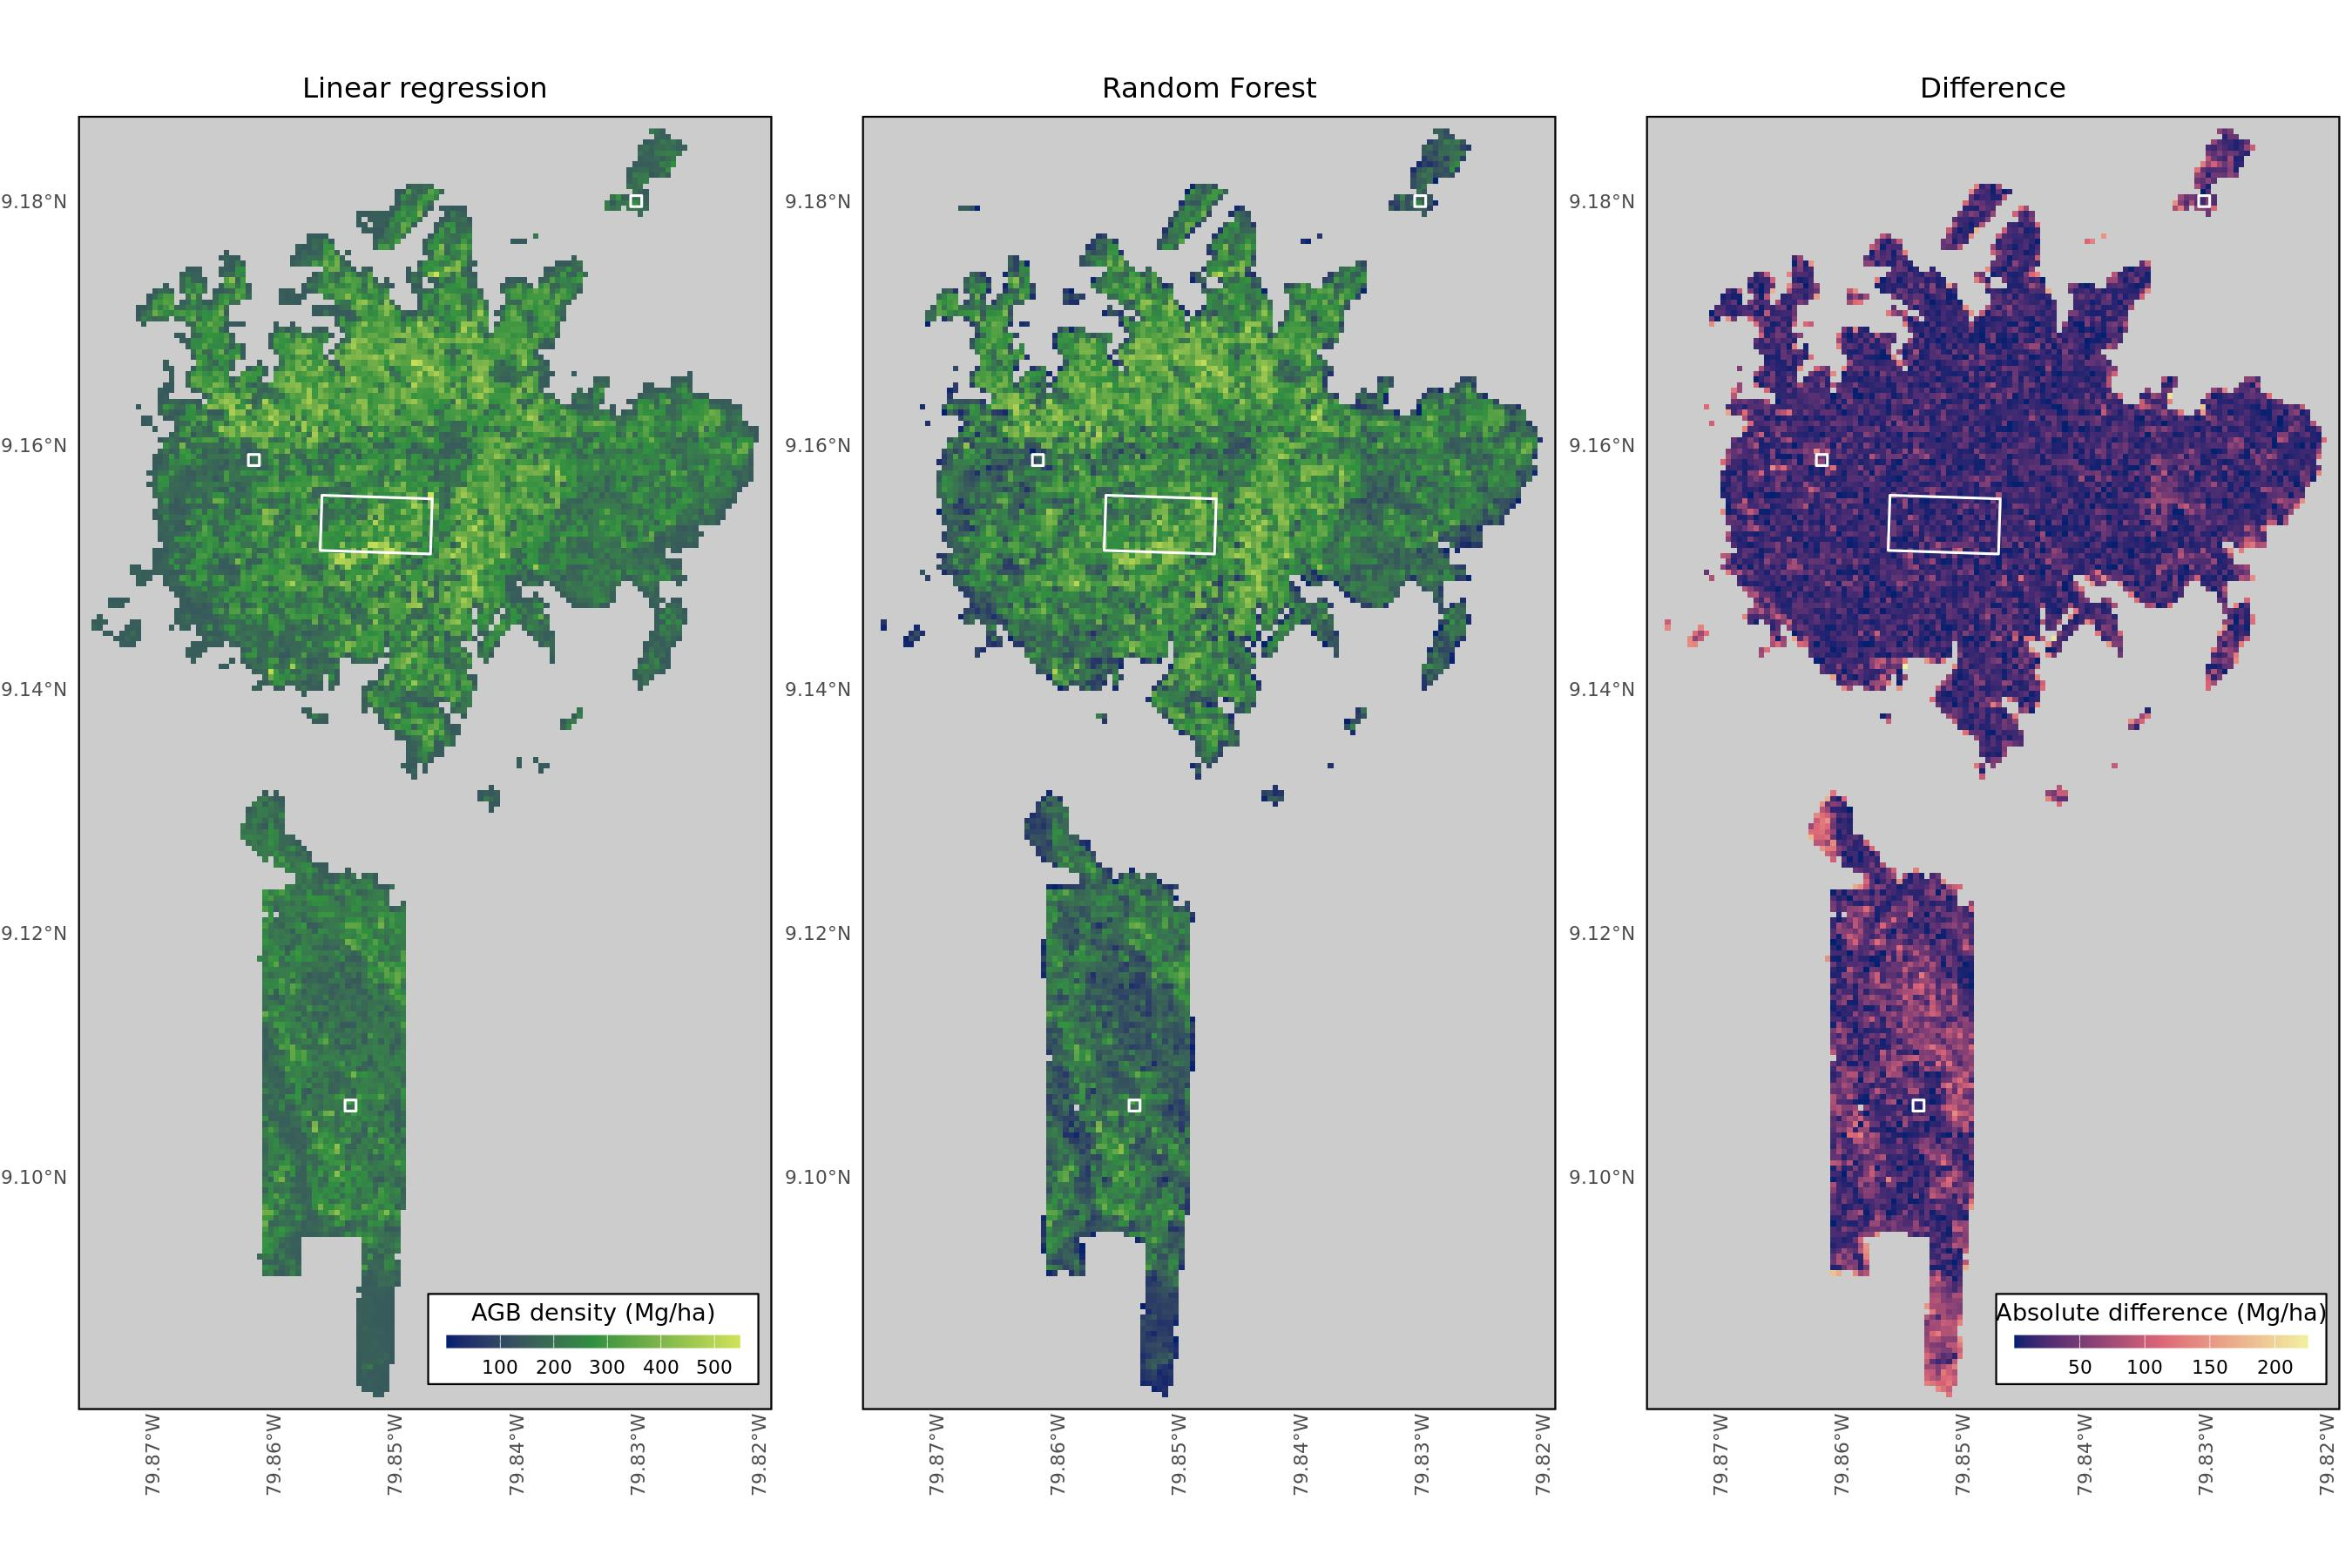

In [37]:
# plot the DTM and CHM for the 50-ha plot

AGB_plot = AGB_predict |>
    clamp(lower = 0, values = FALSE) |>
    trim()

range_AGB = AGB_plot |>
                    minmax()

range_AGB = c(min(range_AGB[,1]), max(range_AGB[,2]))

AGB_dif = abs(AGB_plot$`Linear regression` - AGB_plot$`Random Forest`)

suppressMessages({

    coverage_AGB = ggR(AGB_plot$`Linear regression`,
               geom_raster = TRUE) +
        scale_fill_gradientn(colors = cols_gradient_biomass,
                             na.value = "grey80",
                            limits = c(range_AGB),
                            name = "AGB density (Mg/ha)") +
       geom_sf(data = plots, color = "white", fill = NA, linewidth = .7) +
           scale_x_continuous(expand = expansion(mult = c(.02, .02))) + 
           scale_y_continuous(expand = expansion(mult = c(.01, .01))) +
            ggtitle("Linear regression") +
             theme_bw(base_size = 13) +
           theme_map +
           theme(panel.background = element_rect(fill = "grey80"),
                panel.grid.major = element_blank(),
                plot.title = element_text(hjust = 0.5)) +
            guides(fill = guide_colourbar(title.position="top"))

    coverage_AGB_rf = ggR(AGB_plot$`Random Forest`,
                   geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient_biomass,
                                 na.value = "grey80",
                                limits = c(range_AGB),
                                name = "AGB density (Mg/ha)") +
           geom_sf(data = plots, color = "white", fill = NA, linewidth = .7) +
            ggtitle("Random Forest") +
           scale_x_continuous(expand = expansion(mult = c(.02, .02))) + 
           scale_y_continuous(expand = expansion(mult = c(.01, .01))) +
             theme_bw(base_size = 13) +
           theme_map +
           theme(panel.background = element_rect(fill = "grey80"),
                panel.grid.major = element_blank(),
                plot.title = element_text(hjust = 0.5)) +
            guides(fill = "none")

    coverage_AGB_dif = ggR(AGB_dif,
                   geom_raster = TRUE) +
            scale_fill_gradientn(colors = cols_gradient,
                                 na.value = "grey80",
                                #limits = c(range_AGB),
                                name = "Absolute difference (Mg/ha)") +
           geom_sf(data = plots, color = "white", fill = NA, linewidth = .7) +
            ggtitle("Difference") +
           scale_x_continuous(expand = expansion(mult = c(.02, .02))) + 
           scale_y_continuous(expand = expansion(mult = c(.01, .01))) +
             theme_bw(base_size = 13) +
           theme_map +
           theme(panel.background = element_rect(fill = "grey80"),
                panel.grid.major = element_blank(),
                plot.title = element_text(hjust = 0.5)) +
            guides(fill = guide_colourbar(title.position="top"))

fig = ggarrange(coverage_AGB, coverage_AGB_rf, coverage_AGB_dif,
        ncol = 3, nrow = 1)

})
    
ggsave(plot = fig, 
       filename = "./figures/raster/AGB_predicted.jpeg", 
       device = jpeg,
       width = 18,
       height = 12,
       units = "in",
       dpi = 150,
       bg = "white",
      create.dir = TRUE)

IRdisplay::display_jpeg(file = "./figures/raster/AGB_predicted.jpeg") 


**Predicted AGB density from linear regression and Random Forest models over the 5entire study area, and the absolute difference in predicted values between models.**

<font color='darkgreen'>**Negative AGB values.** How should we deal with negative values produced by models? For this dataset, the Random Forest model produces some negative AGB values, mostly for shoreline pixels that include water and partial forest cover. For the purposes of plotting, I have omitted all negative values. It seems to me that a model that produces negative AGB values is likely poorly calibrated for low biomass. 
</font>

<font color='darkgreen'>**Spatial patterns in model disagreement.** There is some disagreement for shoreline pixels, and also a few large patches of disagreement on the Gigante Peninsula in the southern part of the study area. This area has a fertilization experiment, a liana removal experiment, and contains some secondary forest. I think that this map illustrates something important, if simple: that even with fantastic ALS coverage, the AGB predictions for a site are limited by the forest characteristics sampled by the field plots. Laura and I have discussed this issue, and I think that it should be a larger discussions in the TIG. There are lots of new proposals coming for GEO-TREES sites; some have only one large forest plot, while others have many, scattered, 1-ha plots.
</font>

### **9.** Generate an AGB density reference map for the entire ALS acquisition area.

After selecting the best model for a site through cross validation, use that model to predict AGB density values over the entire ALS coverage area. 

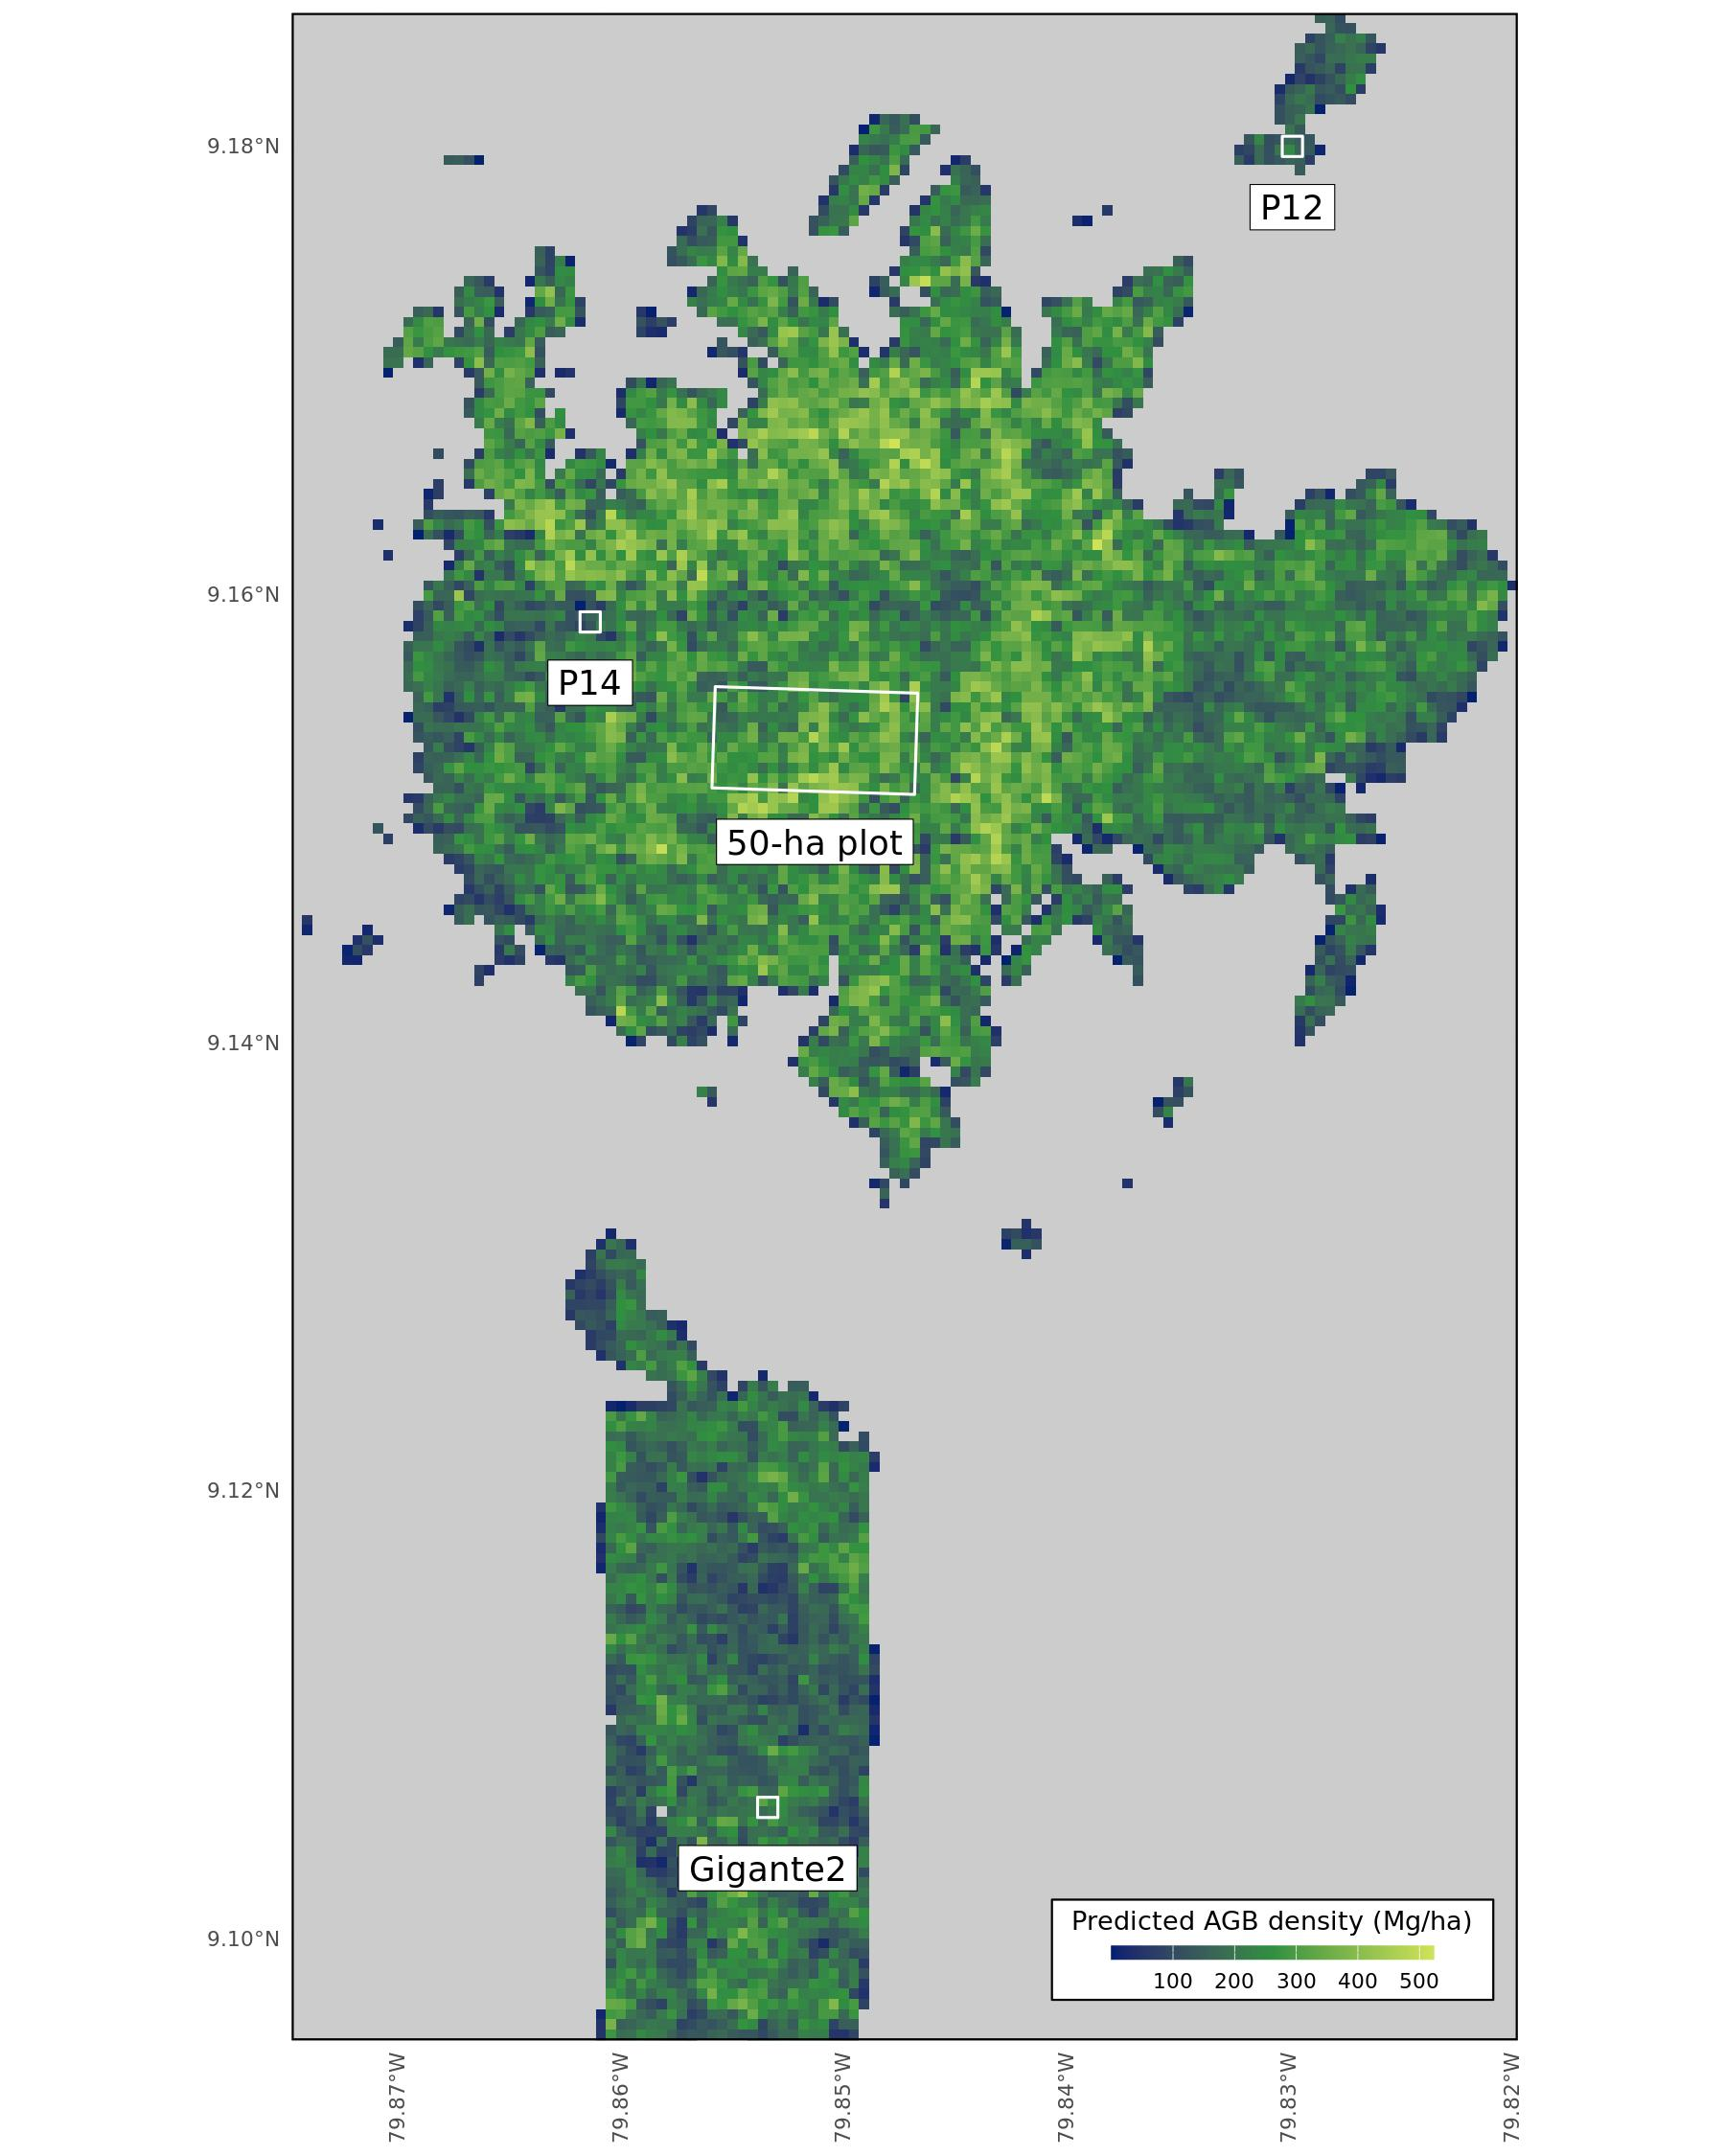

In [38]:
# plot the whole study area 

suppressMessages({

coverage_AGB = ggR(AGB_plot[[1]],
           geom_raster = TRUE) +
    scale_fill_gradientn(colors = cols_gradient_biomass,
                         na.value = "grey80",
                        # limits = c(range_CHM),
                        name = "Predicted AGB density (Mg/ha)") +
   geom_sf(data = plots, color = "white", fill = NA, linewidth = .7) +
     geom_sf_label(data = plots |> filter(NAME != "50-ha plot"), 
                   aes(label = NAME),
                   nudge_y = -300,
                    size = 6, 
            label.r = unit(0, "pt")) +
      geom_sf_label(data = plots |> filter(NAME == "50-ha plot"), 
                   aes(label = NAME),
                   nudge_y = -500,
                    size = 6, 
            label.r = unit(0, "pt")) +
   scale_x_continuous(expand = expansion(mult = c(0, 0))) + 
   scale_y_continuous(expand = expansion(mult = c(-.13, 0))) +
     theme_bw(base_size = 13) +
   theme_map +
    #coord_sf(crs = 32617) +
    guides(fill = guide_colourbar(title.position="top"))

})
    
ggsave(plot = coverage_AGB, 
       filename = "./figures/raster/AGB_BCI_Gigante.jpeg", 
       device = jpeg,
       width = 12,
       height = 15,
       units = "in",
       dpi = 150,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/AGB_BCI_Gigante.jpeg") 


**Predicted AGB density for the ALS acquisition, with field plot boundaries outlined in white. The study area covers all of Barro Colorado Island in the center, a portion of the Buena Vista Peninsula to the north, and a portion of the Gigante Peninsula to the south.**

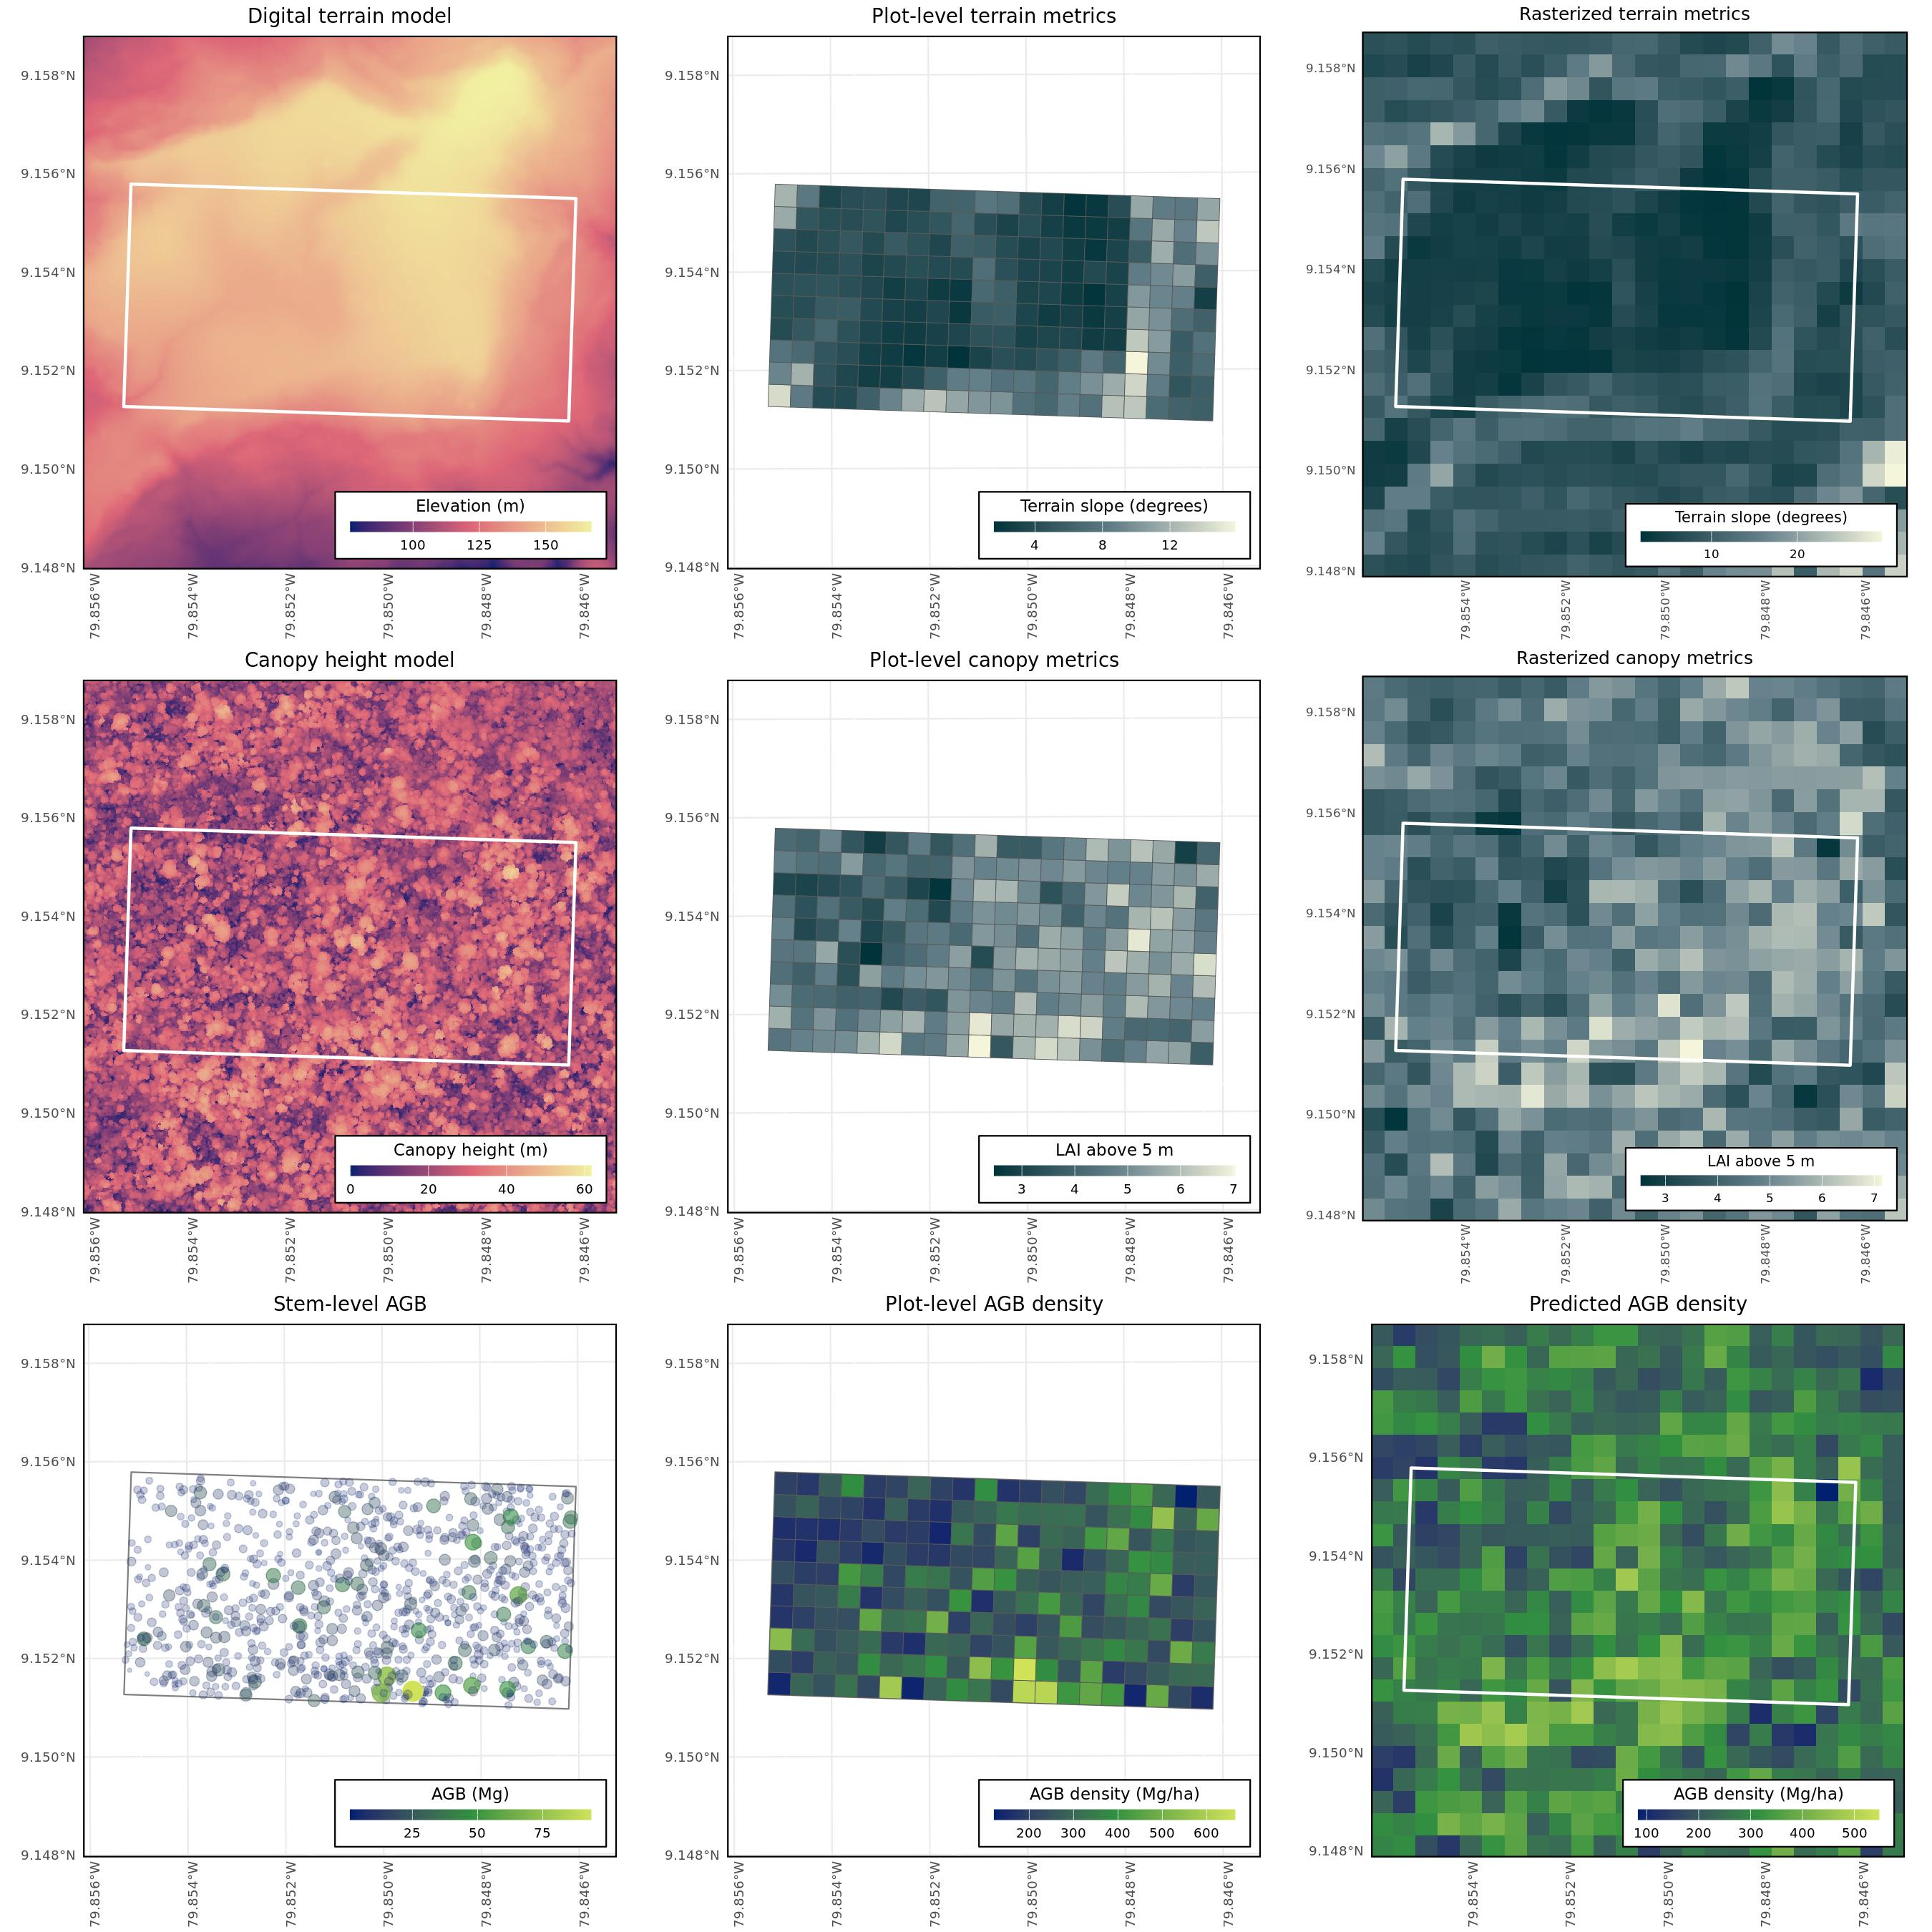

In [39]:
p_LAI_subplots = metrics_list[[3]] +
                  theme(plot.title = element_text(hjust = 0.5))
p_slope_subplots = metrics_list[[5]] +
                  theme(plot.title = element_text(hjust = 0.5))

p_LAI_raster = metrics_list_raster[[3]] +
                  theme(plot.title = element_text(hjust = 0.5))
p_slope_raster = metrics_list_raster[[5]] +
                  theme(plot.title = element_text(hjust = 0.5))

fig = ggarrange(p_DTM, 
                p_slope_subplots + ggtitle("Plot-level terrain metrics"),
                p_slope_raster + ggtitle("Rasterized terrain metrics"),
                p_CHM, 
                p_LAI_subplots + ggtitle("Plot-level canopy metrics"),
                p_LAI_raster + ggtitle("Rasterized canopy metrics"),
                p_AGB_stem,
                p_AGB_subplots + ggtitle("Plot-level AGB density"),  
                p_AGB_raster_rf + ggtitle("Predicted AGB density"), 
        ncol = 3, nrow = 3)

#})
    
ggsave(plot = fig, 
       filename = "./figures/raster/framework_50ha.jpeg", 
       device = jpeg,
       width = 18,
       height = 18,
       units = "in",
       dpi = 150,
       bg = "white")

IRdisplay::display_jpeg(file = "./figures/raster/framework_50ha.jpeg") 




**Illustration of the ALS processing framework for generating AGB density reference maps. Inputs (terrain, canopy, and field plot data) in the lefthand column, subplot-level metrics in the middle column, and area-based raster metrics in the righthand column.**